# Clean memory and set working directory

In [1]:
rm(list = ls()) # clear workspace
gc() # clear memory
setwd("Carolina_data/RNASeq") # set working directory
getwd() # check working directory

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,631329,33.8,1411245,75.4,985811,52.7
Vcells,1169048,9.0,8388608,64.0,1815676,13.9


[1] "/mnt/Data_8TB/Carolina_data/Cell_paper/RNASeq"

# load libraries

In [2]:
library(tidyverse) # load tidyverse for data manipulation and plotting
library(biomaRt) # load biomaRt for ensembl
library(DESeq2) # load DESeq2 for differential expression analysis
library(clusterProfiler) # load clusterProfiler for GO analysis



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’

# Load data

In [20]:
counts_file <- read.table("09_feature_counts/feature_counts.txt", header = T, row.names = 1) # read in counts file
colnames(counts_file) <- gsub("X08_star_alignment_2nd_pass.", "", colnames(counts_file)) # clean column names
colnames(counts_file) <- gsub("__NadiaMercader_RNA_Seq_Directional_S._R1_001.Aligned.sortedByCoord.out.bam", "", colnames(counts_file)) # clean column names
colnames(counts_file) # check column names
counts_file <- counts_file %>% dplyr::select(-c('Chr','Start','End','Strand','Length')) # remove unnecessary columns
head(counts_file) # check file


[1] "Chr"    "Start"  "End"    "Strand" "Length" "KO_10"  "KO_7"   "KO_8"  
 [9] "KO_9"   "WT_1"   "WT_2"   "WT_3"   "WT_5"

,KO_10,KO_7,KO_8,KO_9,WT_1,WT_2,WT_3,WT_5
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSDARG00000103202,0,0,0,4,0,0,0,0
ENSDARG00000009657,1327,811,919,759,1396,1325,1570,1258
ENSDARG00000096472,0,0,0,2,0,0,0,0
ENSDARG00000096156,6,4,8,5,5,6,5,18
ENSDARG00000076160,2,0,6,0,9,7,0,0
ENSDARG00000117163,11,10,3,10,23,11,11,16


In [357]:
# make metadata file

metadata <- data.frame(Sample_Name = colnames(counts_file), row.names = colnames(counts_file)) # make metadata file
rownames(metadata) <- metadata$Sample_Name # set rownames
metadata$condition <- c( rep("WT", 4),rep("Cox7a_KO", 4)) # add condition column
metadata$condition <- factor(metadata$condition, levels = c("Cox7a_KO", "WT")) # set factor levels
metadata <- metadata %>% dplyr::arrange(condition) # arrange by condition
metadata

,Sample_Name,condition
,<chr>,<fct>
KO_10,KO_10,Cox7a_KO
KO_7,KO_7,Cox7a_KO
KO_8,KO_8,Cox7a_KO
KO_9,KO_9,Cox7a_KO
WT_1,WT_1,WT
WT_2,WT_2,WT
WT_3,WT_3,WT
WT_5,WT_5,WT


In [358]:
counts_file <- counts_file[,metadata$Sample_Name] # reorder columns
head(counts_file) # check file
identical(colnames(counts_file), rownames(metadata)) # check if column names and rownames are identical

,KO_10,KO_7,KO_8,KO_9,WT_1,WT_2,WT_3,WT_5
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSDARG00000103202,0,0,0,4,0,0,0,0
ENSDARG00000009657,1327,811,919,759,1396,1325,1570,1258
ENSDARG00000096472,0,0,0,2,0,0,0,0
ENSDARG00000096156,6,4,8,5,5,6,5,18
ENSDARG00000076160,2,0,6,0,9,7,0,0
ENSDARG00000117163,11,10,3,10,23,11,11,16


[1] TRUE

In [359]:
counts_mat <- as.matrix(counts_file) # convert to matrix for DESeq2
head(counts_mat)

,KO_10,KO_7,KO_8,KO_9,WT_1,WT_2,WT_3,WT_5
ENSDARG00000103202,0,0,0,4,0,0,0,0
ENSDARG00000009657,1327,811,919,759,1396,1325,1570,1258
ENSDARG00000096472,0,0,0,2,0,0,0,0
ENSDARG00000096156,6,4,8,5,5,6,5,18
ENSDARG00000076160,2,0,6,0,9,7,0,0
ENSDARG00000117163,11,10,3,10,23,11,11,16


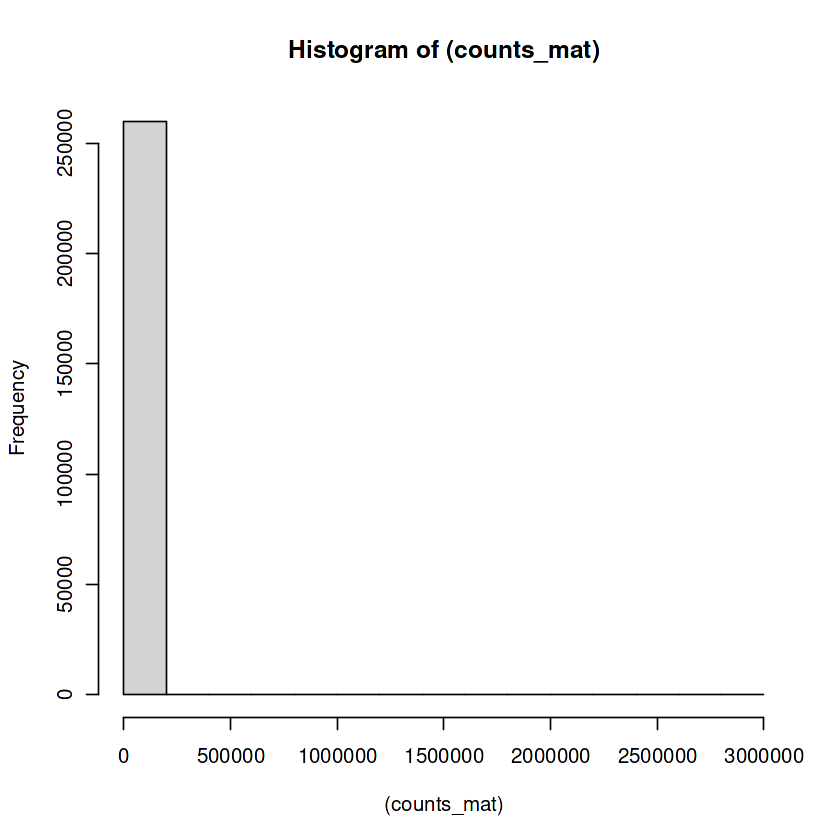

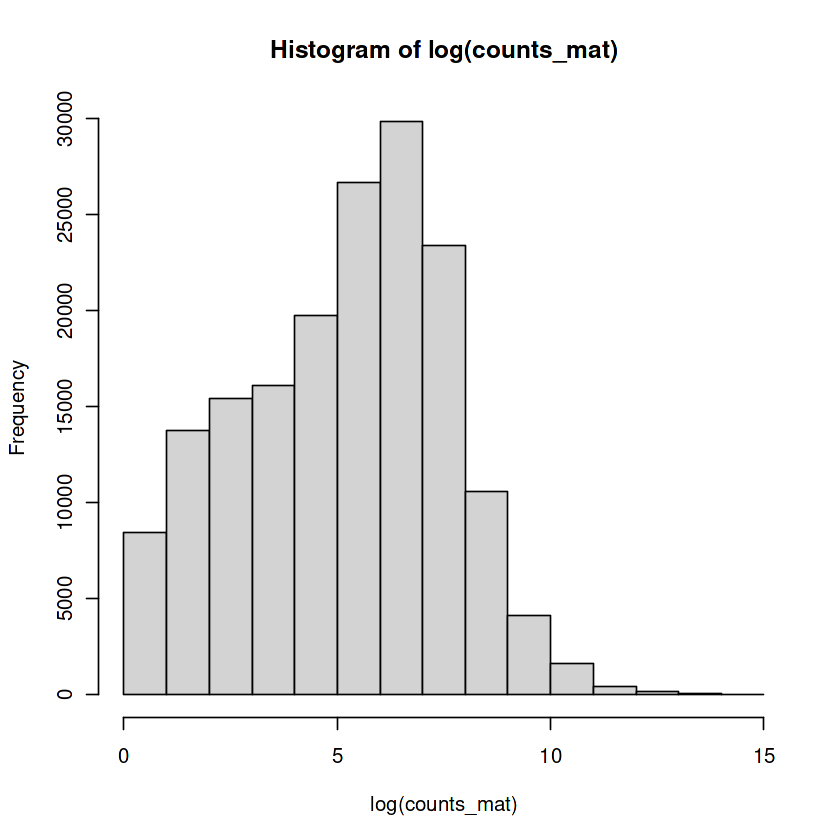

In [360]:
hist((counts_mat)) # check distribution of counts
hist(log(counts_mat)) # check distribution of log counts

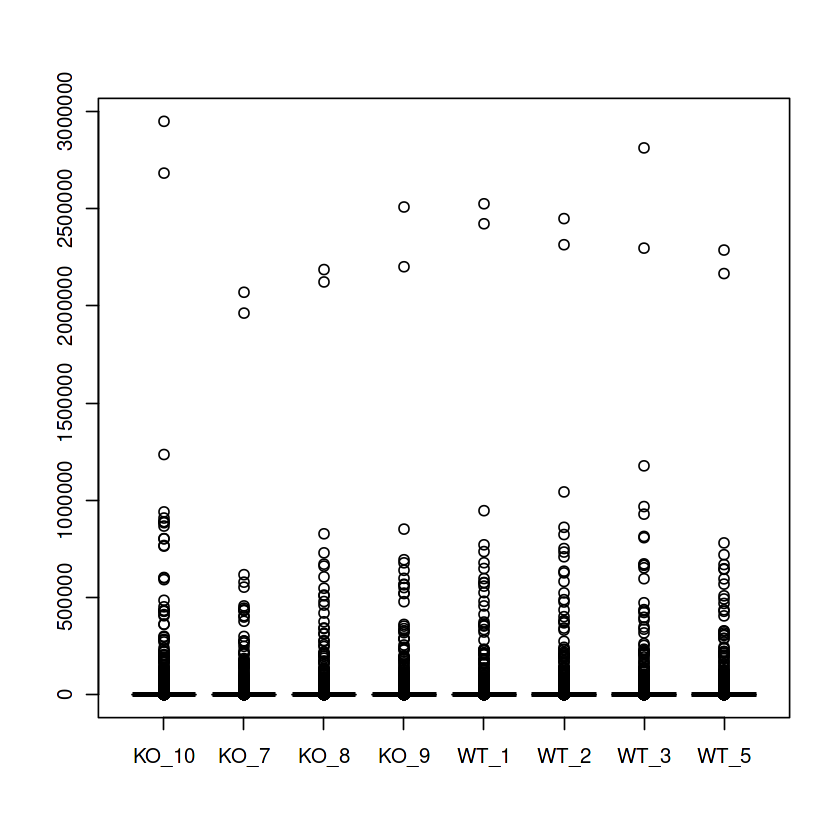

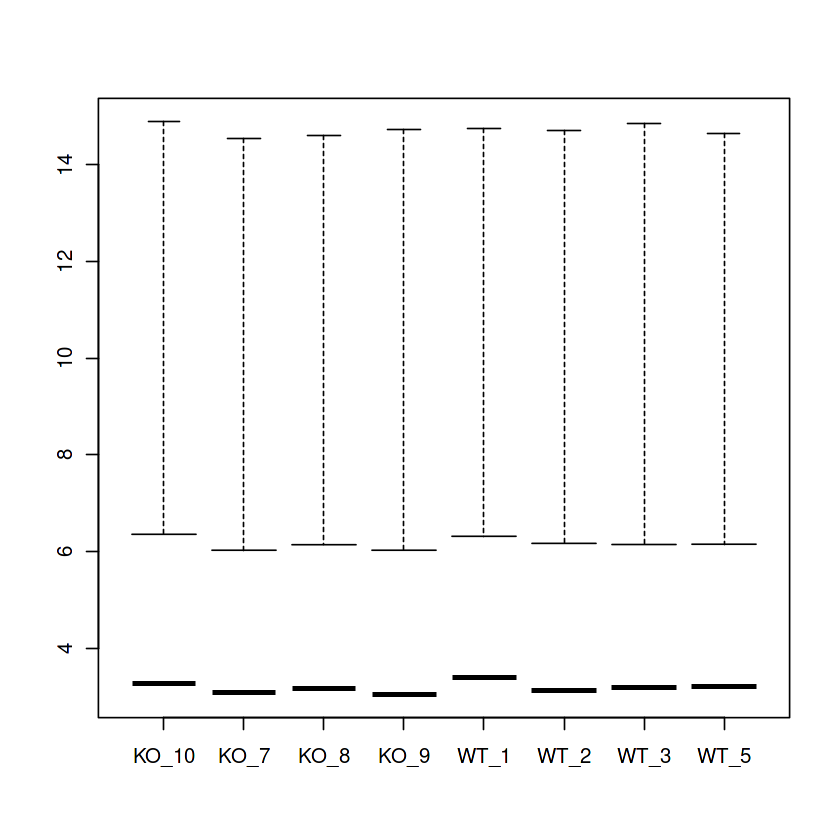

In [361]:
boxplot(counts_mat) # check distribution of counts per sample
boxplot(log(counts_mat)) # check distribution of log counts per sample

In [4]:
sum(is.na(counts_mat)) # check for missing values

[1] 0

# Rum PCA to check for trend and outliers

In [368]:
# Make a PCA function
PCA <- function(mat, color_pca = "", shape_pca = "", label_pca = "", save_plot = "no", name_of_plot = "PCA", comp1 = 1, comp2 = 2, pdf_height=12, pdf_width=12) {
    dt <- mat
    pca_dt <- prcomp(t(dt))
    cat("PCA running...\n")
    percentVar_dt <- pca_dt$sdev^2 / sum(pca_dt$sdev^2)
    cat("Percents calculated...\n")
    dt_f <- data.frame(PC1 = pca_dt$x[, comp1],
                       PC2 = pca_dt$x[, comp2],
                       color_pca = color_pca,
                       shape_pca = shape_pca,
                       label_pca = label_pca)
    cat("Data frame built...\n")
    cat("Plotting...\n")
    require(ggplot2)
    require(ggrepel)
    if (save_plot == "no") {
        pca_p <- ggplot(data = dt_f, aes_string(x = paste0("PC1"),
                                              y = paste0("PC2"),
                                              color = "color_pca",
                                              shape = "shape_pca", label = "label_pca")) +
                geom_point(size = 3) +
                geom_text_repel(size = 3, max.overlaps = 50,
                                box.padding = 1.5, point.padding = 0.5, force = 50) +
                xlab(paste0("PC", comp1, ": ", round(percentVar_dt[comp1] * 100), "% variance")) +
                ylab(paste0("PC", comp2, ": ", round(percentVar_dt[comp2] * 100), "% variance")) +
            NULL
    }
    if (save_plot == "yes") {
        pdf(paste0(name_of_plot, ".pdf"), width = pdf_width, height = pdf_height)
        cat("Saving plot as: ", paste0(name_of_plot, "...\n"))
        pca_p <- ggplot(data = dt_f, aes_string(x = paste0("PC", comp1),
                                              y = paste0("PC", comp2),
                                              color = "color_pca",
                                              shape = "shape_pca", label = "label_pca")) +
                geom_text_repel(size = 3, max.overlaps = 50,
                                box.padding = 1.5,
                                point.padding = 0.5, force = 50) +
                geom_point(size = 3) +
                xlab(paste0("PC", comp1, ": ", round(percentVar_dt[comp1] * 100), "% variance")) +
                ylab(paste0("PC", comp2, ": ", round(percentVar_dt[comp2] * 100), "% variance")) +
            NULL
        print(pca_p)
        dev.off()
    }
    cat("Done")
    print(pca_p)
}

In [369]:
# create a Results directory to store results
dir.create("Results", recursive = T)

Warning message in dir.create("Results", recursive = T):
“'Results' already exists”


PCA running...
Percents calculated...
Data frame built...
Plotting...
Saving plot as:  Results/PCA...
Done

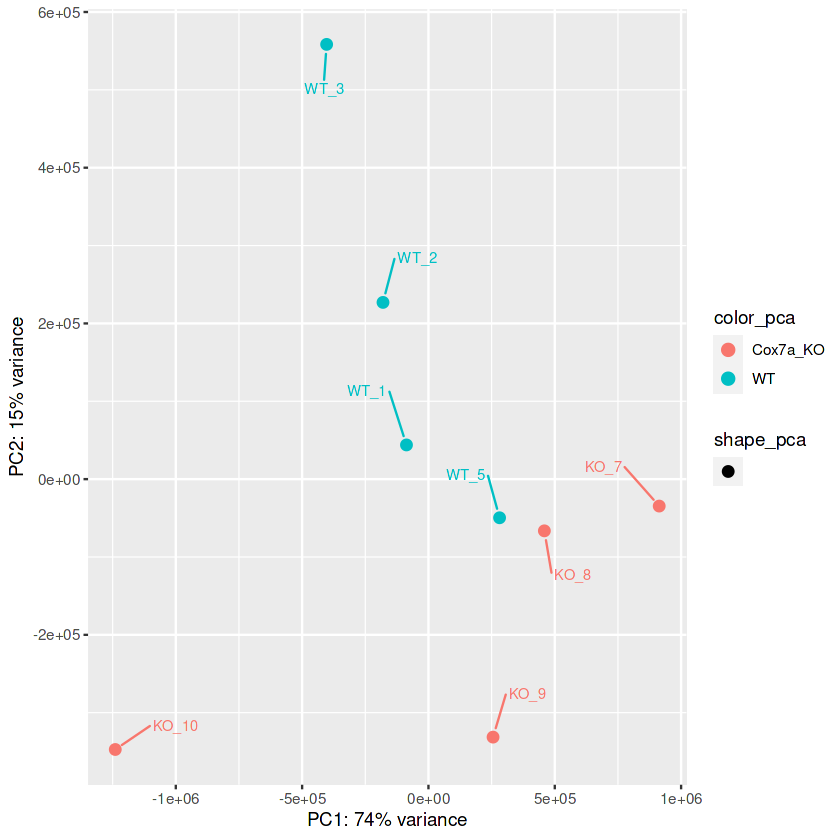

In [370]:
# run PCA on counts matrix
 PCA(counts_mat, color_pca = metadata$condition, shape_pca = "", label_pca = metadata$Sample_Name, save_plot = "yes", name_of_plot = "Results/PCA", comp1 = 1, comp2 = 2, pdf_height=12, pdf_width=12)

PCA running...
Percents calculated...
Data frame built...
Plotting...
Saving plot as:  Results/PCA_log...
Done

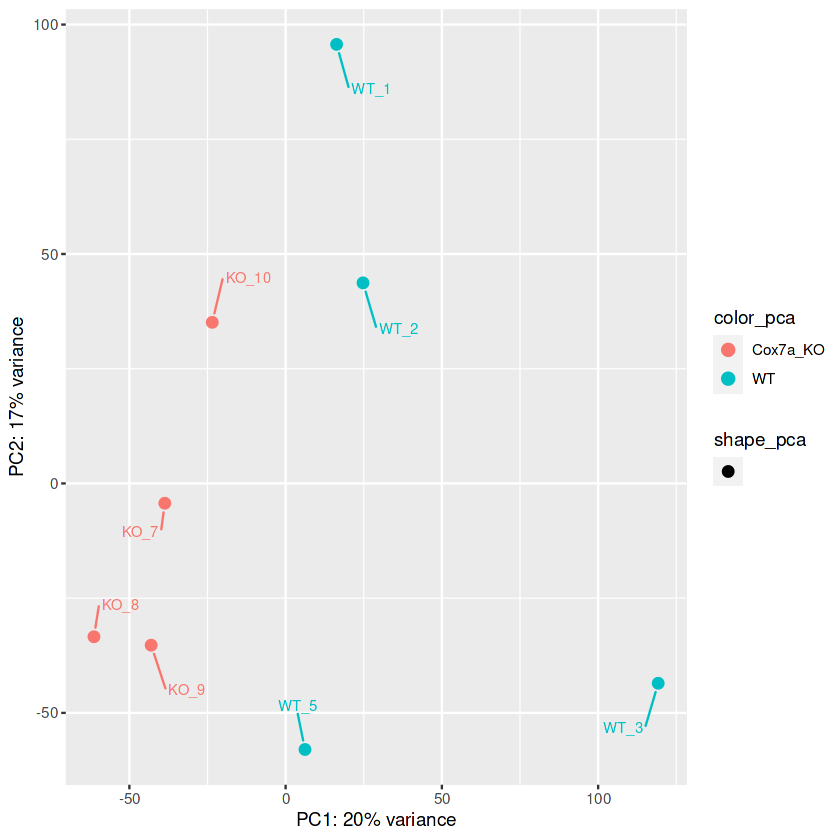

In [371]:
# Run PCA on log counts matrix
PCA(log2(counts_mat+1), color_pca = metadata$condition, shape_pca = "", label_pca = metadata$Sample_Name, save_plot = "yes", name_of_plot = "Results/PCA_log", comp1 = 1, comp2 = 2, pdf_height=12, pdf_width=12)

# Run Desq2 analysis

In [372]:

dds <- DESeqDataSetFromMatrix(countData=counts_mat, 
                              colData=metadata, 
                              design=~condition) # make DESeq2 object

In [373]:
keep <- rowSums(counts(dds)) >= 10 # keep genes with at least 10 counts
dds_filtered <- dds[keep,] # filter based on keep
dds
dds_filtered

class: DESeqDataSet 
dim: 32520 8 
metadata(1): version
assays(1): counts
rownames(32520): ENSDARG00000103202 ENSDARG00000009657 ...
  ENSDARG00000101098 ENSDARG00000103574
rowData names(0):
colnames(8): KO_10 KO_7 ... WT_3 WT_5
colData names(2): Sample_Name condition

class: DESeqDataSet 
dim: 22343 8 
metadata(1): version
assays(1): counts
rownames(22343): ENSDARG00000009657 ENSDARG00000096156 ...
  ENSDARG00000104659 ENSDARG00000103574
rowData names(0):
colnames(8): KO_10 KO_7 ... WT_3 WT_5
colData names(2): Sample_Name condition

In [375]:
dds_filtered <- DESeq(dds_filtered, parallel = T) # run DESeq2


estimating size factors

estimating dispersions

gene-wise dispersion estimates: 10 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 10 workers



In [376]:
resultsNames(dds_filtered) # check results names

[1] "Intercept"                "condition_WT_vs_Cox7a_KO"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



[1] "lfcshrinakge done..."


,baseMean,log2FoldChange,lfcSE,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSDARG00000009657,1148.306489,-0.36641431,0.1427850,0.0006226866,0.0174343
ENSDARG00000096156,7.096952,-0.03537140,0.2289743,0.5484592047,0.8261124
ENSDARG00000076160,2.820730,-0.01481899,0.2532079,0.6445563313,NA
ENSDARG00000117163,11.589063,-0.07815191,0.2323184,0.2686859935,0.6245806
ENSDARG00000096187,5.993731,0.03185551,0.2452809,0.4728926837,NA
ENSDARG00000076014,275.688504,0.04408028,0.1413125,0.6193406672,0.8594960


,baseMean,log2FoldChange,lfcSE,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSDARG00000089791,958.0652,-1.347831,0.1313111,7.575781e-27,1.427504e-22
ENSDARG00000035519,1963.6138,-1.527732,0.1533885,2.001634e-25,1.885839e-21
ENSDARG00000063307,879.0429,1.395107,0.1581055,7.882223e-21,4.950824e-17
ENSDARG00000025788,400.3032,-1.175105,0.1511315,1.770101e-17,8.338505e-14
ENSDARG00000068374,2936.7863,1.009402,0.1341592,9.013761e-17,3.396926e-13
ENSDARG00000055723,325.0561,1.555549,0.2051782,1.627645e-16,5.111620e-13


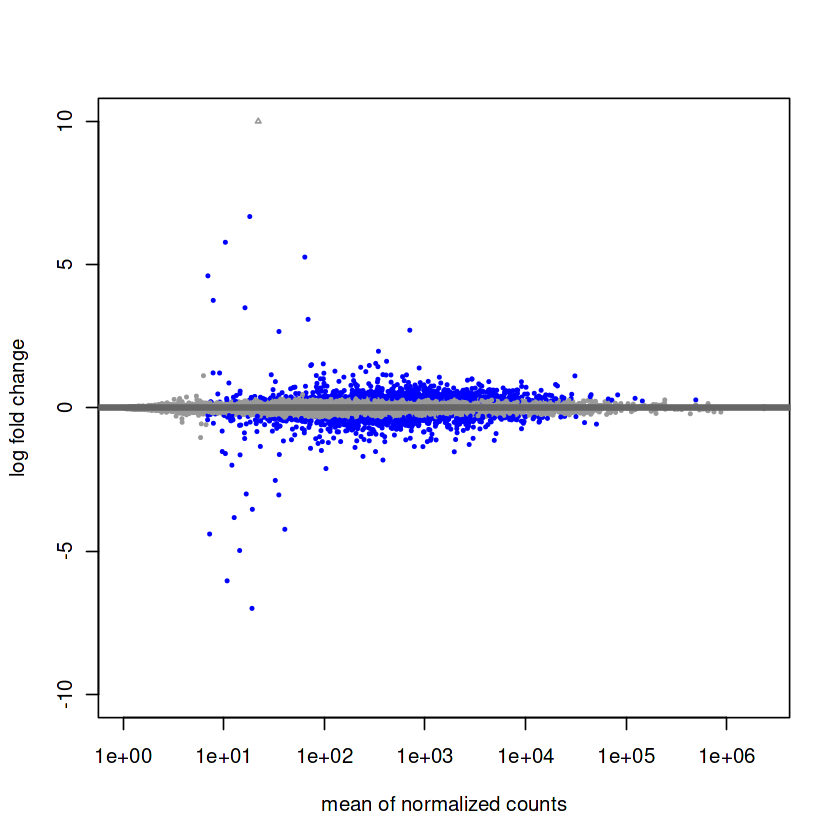

In [377]:
results_WT_KO <- lfcShrink(dds_filtered, contrast = c("condition","Cox7a_KO","WT"), 
                           parallel=TRUE, type = "ashr") # shrink log fold changes using ashr method for Cox7a_KO vs WT
print("lfcshrinakge done...")
results_WT_KO_df <- as.data.frame(results_WT_KO) # convert to data frame
head(results_WT_KO_df)
plotMA(results_WT_KO, ylim=c(-10,10)) # plot MA plot
results_WT_KO_df <- results_WT_KO_df %>% dplyr::arrange(padj) # arrange by padj
head(results_WT_KO_df)




In [378]:
results_WT_KO_df %>% filter(padj < 0.05) %>% dim  # check number of DEGs with padj < 0.05

[1] 1070    5

In [379]:
gtf <- rtracklayer::import('/mnt/Data_8TB/Genomes/v109/Danio_rerio.GRCz11.109.gtf') # import gtf file for zebrafish to get gene names
gtf_df <- as.data.frame(gtf)
head(gtf_df)
gtf_df %>% colnames

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,transcript_version,transcript_name,transcript_source,transcript_biotype,tag,exon_number,exon_id,exon_version,protein_id,protein_version
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,4,30402837,30403763,927,+,havana,gene,NA,NA,ENSDARG00000103202,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,4,30402837,30403763,927,+,havana,transcript,NA,NA,ENSDARG00000103202,⋯,2,CR383668.1-201,havana,lincRNA,Ensembl_canonical,NA,NA,NA,NA,NA
3,4,30402837,30402893,57,+,havana,exon,NA,NA,ENSDARG00000103202,⋯,2,CR383668.1-201,havana,lincRNA,Ensembl_canonical,1,ENSDARE00001204173,1,NA,NA
4,4,30403203,30403350,148,+,havana,exon,NA,NA,ENSDARG00000103202,⋯,2,CR383668.1-201,havana,lincRNA,Ensembl_canonical,2,ENSDARE00001194706,1,NA,NA
5,4,30403546,30403763,218,+,havana,exon,NA,NA,ENSDARG00000103202,⋯,2,CR383668.1-201,havana,lincRNA,Ensembl_canonical,3,ENSDARE00001199782,1,NA,NA
6,4,1722899,1730920,8022,+,ensembl_havana,gene,NA,NA,ENSDARG00000009657,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "seqnames"           "start"              "end"               
 [4] "width"              "strand"             "source"            
 [7] "type"               "score"              "phase"             
[10] "gene_id"            "gene_version"       "gene_name"         
[13] "gene_source"        "gene_biotype"       "transcript_id"     
[16] "transcript_version" "transcript_name"    "transcript_source" 
[19] "transcript_biotype" "tag"                "exon_number"       
[22] "exon_id"            "exon_version"       "protein_id"        
[25] "protein_version"

In [380]:
cox_genes <- gtf_df %>% filter(grepl("cox", gene_name)) %>% filter(type=="gene") %>% dplyr::select(gene_id, 
gene_name) # get cox genes
cox_genes

gene_id,gene_name
<chr>,<chr>
ENSDARG00000038865,acox3
ENSDARG00000104537,cox7c
ENSDARG00000054588,cox6a2
ENSDARG00000038577,cox6c
ENSDARG00000014727,acox1
ENSDARG00000069920,cox17
ENSDARG00000037860,cox6b2
ENSDARG00000022438,cox6a1
ENSDARG00000053217,cox7a2a


In [381]:
gtf_df <- gtf_df %>% dplyr::select(gene_id, gene_name) # select gene_id and gene_name columns
gtf_df  <- gtf_df %>% dplyr::distinct() # remove duplicates
gtf_df$gene_id %>% duplicated() %>% sum() # check for duplicates
head(gtf_df)  # check file

[1] 0

,gene_id,gene_name
,<chr>,<chr>
1,ENSDARG00000103202,CR383668.1
2,ENSDARG00000009657,fgfr1op2
3,ENSDARG00000096472,AL845295.2
4,ENSDARG00000096156,si:dkey-21h14.12
5,ENSDARG00000076160,si:dkey-285e18.2
6,ENSDARG00000117163,znf1114


In [409]:
# convert gene_id to gene_name
symbol_to_ensmbl_danio <- function(x) {
    require(biomaRt) # load biomaRt package
    zf_mart <- useMart(biomart = "ensembl", dataset = "drerio_gene_ensembl") # use the ensembl mart
    results <- getBM(attributes = c("ensembl_gene_id", "zfin_id_symbol", "description"), # get ensembl gene id, zfin id symbol and description
                     filters = "ensembl_gene_id", # filter by ensembl gene id
                     values = x,
                     mart = zf_mart)
    results
}
description <- symbol_to_ensmbl_danio(gtf_df$gene_id)
description <- as.data.frame(description)
head(description)

,ensembl_gene_id,zfin_id_symbol,description
,<chr>,<chr>,<chr>
1,ENSDARG00000000018,nrf1,nuclear respiratory factor 1 [Source:NCBI gene;Acc:64604]
2,ENSDARG00000000019,ube2h,"ubiquitin-conjugating enzyme E2H (UBC8 homolog, yeast) [Source:ZFIN;Acc:ZDB-GENE-030616-67]"
3,ENSDARG00000000423,si:ch73-314g15.3,si:ch73-314g15.3 [Source:ZFIN;Acc:ZDB-GENE-030616-19]
4,ENSDARG00000000442,slc39a13,solute carrier family 39 member 13 [Source:NCBI gene;Acc:368686]
5,ENSDARG00000000460,nitr2b,novel immune-type receptor 2b [Source:ZFIN;Acc:ZDB-GENE-001106-6]
6,ENSDARG00000000767,spi1b,Spi-1 proto-oncogene b [Source:ZFIN;Acc:ZDB-GENE-980526-164]


In [382]:
results_WT_KO_df$ensembl_gene_id <- rownames(results_WT_KO_df) # add ensembl gene id column
results_WT_KO_df %>% head # check file
# convert ensemble to symbol by merging with gtf_df
results_WT_KO_df_gene <- merge(results_WT_KO_df, gtf_df, by.x = "ensembl_gene_id", by.y = "gene_id", all.x = T)
results_WT_KO_df_gene %>% head()
results_WT_KO_df_gene$gene_name %>% duplicated() %>% sum()
results_WT_KO_df_gene$gene_name %>% is.na() %>% sum()
results_WT_KO_df_gene <- results_WT_KO_df_gene %>% dplyr::arrange(padj)
write.csv(results_WT_KO_df_gene, "Results/DEGs_KO_vs_WT.csv")

,baseMean,log2FoldChange,lfcSE,pvalue,padj,ensembl_gene_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSDARG00000089791,958.0652,-1.347831,0.1313111,7.575781e-27,1.427504e-22,ENSDARG00000089791
ENSDARG00000035519,1963.6138,-1.527732,0.1533885,2.001634e-25,1.885839e-21,ENSDARG00000035519
ENSDARG00000063307,879.0429,1.395107,0.1581055,7.882223e-21,4.950824e-17,ENSDARG00000063307
ENSDARG00000025788,400.3032,-1.175105,0.1511315,1.770101e-17,8.338505e-14,ENSDARG00000025788
ENSDARG00000068374,2936.7863,1.009402,0.1341592,9.013761e-17,3.396926e-13,ENSDARG00000068374
ENSDARG00000055723,325.0561,1.555549,0.2051782,1.627645e-16,5.111620e-13,ENSDARG00000055723


,ensembl_gene_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,gene_name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSDARG00000000001,163.3757,0.00501928,0.1534130,9.547782e-01,9.883977e-01,slc35a5
2,ENSDARG00000000002,2654.8789,0.97021886,0.1397340,6.984866e-15,1.880226e-11,ccdc80
3,ENSDARG00000000018,723.0188,-0.08979923,0.1318007,3.106098e-01,6.650933e-01,nrf1
4,ENSDARG00000000019,4076.2952,-0.21684774,0.1074539,1.142926e-02,1.197784e-01,ube2h
5,ENSDARG00000000068,558.9280,0.05265276,0.1018394,4.851408e-01,7.935337e-01,slc9a3r1a
6,ENSDARG00000000069,848.1649,0.07789406,0.1166314,3.470132e-01,6.974199e-01,dap


[1] 426

[1] 63

In [411]:
results_WT_KO_df_gene_description <- merge(results_WT_KO_df_gene, description, by.x = "ensembl_gene_id", by.y = "ensembl_gene_id", all.x = T) # merge with description
results_WT_KO_df_gene_description %>% head 
write.csv(results_WT_KO_df_gene_description, "Results/DEGs_KO_vs_WT_description.csv")

,ensembl_gene_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,gene_name,zfin_id_symbol,description
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,ENSDARG00000000001,163.3757,0.00501928,0.1534130,9.547782e-01,9.883977e-01,slc35a5,slc35a5,solute carrier family 35 member A5 [Source:NCBI gene;Acc:368418]
2,ENSDARG00000000002,2654.8789,0.97021886,0.1397340,6.984866e-15,1.880226e-11,ccdc80,ccdc80,coiled-coil domain containing 80 [Source:NCBI gene;Acc:368419]
3,ENSDARG00000000018,723.0188,-0.08979923,0.1318007,3.106098e-01,6.650933e-01,nrf1,nrf1,nuclear respiratory factor 1 [Source:NCBI gene;Acc:64604]
4,ENSDARG00000000019,4076.2952,-0.21684774,0.1074539,1.142926e-02,1.197784e-01,ube2h,ube2h,"ubiquitin-conjugating enzyme E2H (UBC8 homolog, yeast) [Source:ZFIN;Acc:ZDB-GENE-030616-67]"
5,ENSDARG00000000068,558.9280,0.05265276,0.1018394,4.851408e-01,7.935337e-01,slc9a3r1a,slc9a3r1a,SLC9A3 regulator 1a [Source:ZFIN;Acc:ZDB-GENE-031006-7]
6,ENSDARG00000000069,848.1649,0.07789406,0.1166314,3.470132e-01,6.974199e-01,dap,dap,death-associated protein [Source:ZFIN;Acc:ZDB-GENE-000511-3]


# plot volcano plot

In [385]:
# prepare data for volcano plot
results_WT_KO_df_gene_volcano <- results_WT_KO_df_gene
results_WT_KO_df_gene_volcano$padj[is.na(results_WT_KO_df_gene_volcano$padj)] <- 1 # replace NA with 1 because as NA is non significant 
results_WT_KO_df_gene_volcano$ens_gene <- results_WT_KO_df_gene_volcano$gene_name
results_WT_KO_df_gene_volcano$ens_gene[is.na(results_WT_KO_df_gene_volcano$ens_gene)] <- results_WT_KO_df_gene_volcano$ensembl_gene_id
results_WT_KO_df_gene_volcano <- results_WT_KO_df_gene_volcano %>% dplyr::arrange(padj)
results_WT_KO_df_gene_volcano %>% head

Warning message in results_WT_KO_df_gene_volcano$ens_gene[is.na(results_WT_KO_df_gene_volcano$ens_gene)] <- results_WT_KO_df_gene_volcano$ensembl_gene_id:
“number of items to replace is not a multiple of replacement length”


,ensembl_gene_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,gene_name,ens_gene
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,ENSDARG00000089791,958.0652,-1.347831,0.1313111,7.575781e-27,1.427504e-22,slc25a32a,slc25a32a
2,ENSDARG00000035519,1963.6138,-1.527732,0.1533885,2.001634e-25,1.885839e-21,histh1l,histh1l
3,ENSDARG00000063307,879.0429,1.395107,0.1581055,7.882223e-21,4.950824e-17,sgsm2,sgsm2
4,ENSDARG00000025788,400.3032,-1.175105,0.1511315,1.770101e-17,8.338505e-14,chp2,chp2
5,ENSDARG00000068374,2936.7863,1.009402,0.1341592,9.013761e-17,3.396926e-13,si:ch211-132b12.7,si:ch211-132b12.7
6,ENSDARG00000055723,325.0561,1.555549,0.2051782,1.627645e-16,5.111620e-13,hsp70l,hsp70l


 [1] "slc25a32a"         "histh1l"           "sgsm2"            
 [4] "chp2"              "si:ch211-132b12.7" "hsp70l"           
 [7] "ccdc80"            "ywhag2"            "namptb"           
[10] "BX901920.1"        "hspa4a"            "myo1hb"           
[13] "h1-0"              "sik2a"             "gstt2"            
[16] "hsp90aa1.1"        "mindy4b"           "lmod2a"           
[19] "h1-10"             "aldh3a1"           "hspa5"            
[22] "ypel3"             "zgc:77784"         "hk2"              
[25] "pprc1"             "BX649453.1"        "BX323060.3"       
[28] "alpi.1"            "CU929150.1"        "ccsapb"           


pdf 
  4

png 
  2

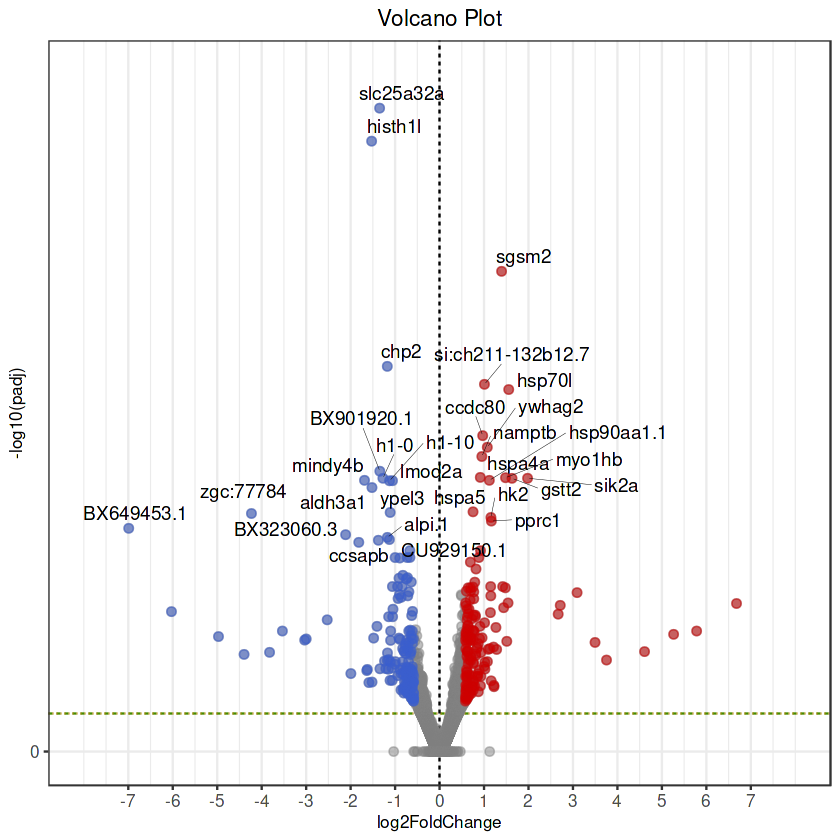

In [386]:
# function to draw volcano plot
require(ggplot2)
require(ggrepel)
require(clusterProfiler)
require(tidyverse)
options(ggrepel.max.overlaps = z`50)
draw_volcano <- function(fileinput, title, lfcthres=1) { 
    # fileinput: data frame with log2FoldChange and padj columns
    # title: title of the plot
    # lfcthres: log2 fold change threshold
    ggplot(data = fileinput , aes(x = log2FoldChange, y = -log10(padj))) + # make ggplot object with log2FoldChange and -log10(padj)
        geom_hline(yintercept = -log10(0.05), linetype = "dotted", col = "darkgoldenrod") + # add horizontal line for padj = 0.05
        geom_vline(xintercept = 0, linetype = "dashed") + # add vertical line for log2FoldChange = 0
        geom_point(x = fileinput$log2FoldChange, y = -log10(fileinput$padj),alpha = 0.5, size = 2,color="grey51") + # add points with color grey
        geom_point(data = fileinput[which(fileinput$padj < 0.05 & fileinput$log2FoldChange < -lfcthres),],# add points with padj < 0.05 and log2FoldChange < -lfcthres with color blue
                   aes(x=log2FoldChange, y = -log10(padj)), shape = 21, color = "royalblue3", fill = "royalblue3",
                   alpha = 0.5, size = 2) +
        geom_point(data = fileinput[which(fileinput$padj < 0.05 & fileinput$log2FoldChange > lfcthres),], # add points with padj < 0.05 and log2FoldChange > lfcthres with color red
                   aes(x=log2FoldChange, y = -log10(padj)), shape = 21, color = "red3", fill = "red3",
                   alpha = 0.5, size = 2) +
        scale_x_continuous(breaks = seq(round(min(fileinput$log2FoldChange)- 0.5),
                                        round(max(fileinput$log2FoldChange)+ 0.5),by = 1),
                           limits = c(round(min(fileinput$log2FoldChange)-1),round(max(fileinput$log2FoldChange)+1))) + # set x axis limits
        scale_y_continuous(breaks = seq(0,round(-log10(min(fileinput$padj)+1)),by = 4),
                           limits = c(0,round(-log10(min(fileinput$padj))+1))) + # set y axis limits
        ggtitle(title) +# add title based on input
        theme_bw() + # set theme to black and white
        theme(plot.title = element_text(hjust = 0.5), axis.text = element_text(size = 10),# set theme for plot title and axis text
              axis.title.x = element_text(size = 10), axis.title.y = element_text(size = 10))
}
# Draw volcano plot
b = draw_volcano(results_WT_KO_df_gene_volcano, "Volcano Plot",lfcthres = 0.58)
# Add labels for significant genes:
gene_name <- results_WT_KO_df_gene_volcano %>% arrange(padj) %>% pull(ens_gene) %>% as.character() %>% head(30) # select top 30 genes for labeling
print(gene_name)
c = b + geom_text_repel(data = results_WT_KO_df_gene_volcano[results_WT_KO_df_gene_volcano$ens_gene %in% gene_name,], aes(label = gene_name),
                         nudge_x = 0.5, nudge_y = 0.5, segment.size = 0.1) # add labels for significant genes to the plot
# Save the plot with labels:
print(c)
dev.copy(pdf, file = "Results/Volcano_plot.pdf", width = 12, height = 12)
dev.off()

# Perform Pathway analysis

In [390]:
# Basic function to convert zebrafish to mouse gene names

zgGenes <- results_WT_KO_df_gene$ensembl_gene_id

# This function uses biomaRt to convert zebrafish gene names to mouse gene names. 
# This is done by using the zebrafish and mouse ensembl mart datasets. 
# The function takes a vector of zebrafish gene names as input and returns 
# a data frame of zebrafish and mouse gene names.

convertDanioGeneList_Mouse <- function(x){ 
  require("biomaRt") # load biomaRt package
  mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl", host = "https://dec2021.archive.ensembl.org/") # use mouse mart
  danio = useMart("ensembl", dataset = "drerio_gene_ensembl", host = "https://dec2021.archive.ensembl.org/") # use zebrafish mart
  
  genesV2 = getLDS(attributes = c("ensembl_gene_id", "zfin_id_symbol"), 
                   filters = "ensembl_gene_id", # get zebrafish gene names
                   values = x , # use the zebrafish gene names
                   mart = danio,  # use the zebrafish mart
                   attributesL = c("mgi_symbol", "ensembl_gene_id", "description"), # get mouse gene names
                   martL = mouse, uniqueRows=T) # use the mouse mart
  
  colnames(genesV2)[colnames(genesV2)== "Gene.stable.ID"] <- "EnsmblID_Zebrafish" # rename columns
  colnames(genesV2)[colnames(genesV2)== "Gene.stable.ID.1"] <- "EnsmblID_Mouse" # rename columns
  
  # Check if the gene is not found
  if (length(genesV2) == 0) {
    print("No gene found for this input")
  } else { 
    return(genesV2) # return the genes
  }
}

# Run the function
Mouse_Genes <- convertDanioGeneList_Mouse(zgGenes)
# print the first 6 genes
print(head(Mouse_Genes))

  EnsmblID_Zebrafish ZFIN.symbol MGI.symbol     EnsmblID_Mouse
1 ENSDARG00000063908      mt-co2     mt-Co2 ENSMUSG00000064354
2 ENSDARG00000013438       sycp3    Gm20817 ENSMUSG00000100032
3 ENSDARG00000013438       sycp3    Gm28490 ENSMUSG00000094789
4 ENSDARG00000013438       sycp3    Gm21094 ENSMUSG00000095263
5 ENSDARG00000013438       sycp3    Gm20838 ENSMUSG00000095011
6 ENSDARG00000013438       sycp3    Gm20888 ENSMUSG00000094616
                                                                    Gene.description
1 mitochondrially encoded cytochrome c oxidase II [Source:MGI Symbol;Acc:MGI:102503]
2                          predicted gene, 20817 [Source:MGI Symbol;Acc:MGI:5434173]
3                           predicted gene 28490 [Source:MGI Symbol;Acc:MGI:5579196]
4                          predicted gene, 21094 [Source:MGI Symbol;Acc:MGI:5434449]
5                          predicted gene, 20838 [Source:MGI Symbol;Acc:MGI:5434194]
6                          predicted gene, 20888 

In [391]:
# merge with results_WT_KO_df_gene to get mouse gene names
 results_WT_KO_df_gene_mouse <- merge(results_WT_KO_df, Mouse_Genes, by.x = "ensembl_gene_id", by.y = "EnsmblID_Zebrafish", all.x = T)
results_WT_KO_df_gene_mouse %>% head

,ensembl_gene_id,baseMean,log2FoldChange,lfcSE,pvalue,padj,ZFIN.symbol,MGI.symbol,EnsmblID_Mouse,Gene.description
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,ENSDARG00000000001,163.3757,0.00501928,0.1534130,9.547782e-01,9.883977e-01,slc35a5,Slc35a5,ENSMUSG00000022664,"solute carrier family 35, member A5 [Source:MGI Symbol;Acc:MGI:1921352]"
2,ENSDARG00000000002,2654.8789,0.97021886,0.1397340,6.984866e-15,1.880226e-11,NA,NA,NA,NA
3,ENSDARG00000000018,723.0188,-0.08979923,0.1318007,3.106098e-01,6.650933e-01,nrf1,Nrf1,ENSMUSG00000058440,nuclear respiratory factor 1 [Source:MGI Symbol;Acc:MGI:1332235]
4,ENSDARG00000000019,4076.2952,-0.21684774,0.1074539,1.142926e-02,1.197784e-01,ube2h,Ube2h,ENSMUSG00000039159,ubiquitin-conjugating enzyme E2H [Source:MGI Symbol;Acc:MGI:104632]
5,ENSDARG00000000068,558.9280,0.05265276,0.1018394,4.851408e-01,7.935337e-01,slc9a3r1a,Slc9a3r1,ENSMUSG00000020733,"solute carrier family 9 (sodium/hydrogen exchanger), member 3 regulator 1 [Source:MGI Symbol;Acc:MGI:1349482]"
6,ENSDARG00000000069,848.1649,0.07789406,0.1166314,3.470132e-01,6.974199e-01,dap,Dap,ENSMUSG00000039168,death-associated protein [Source:MGI Symbol;Acc:MGI:1918190]


In [392]:
# GO analysis function for DEGs
GO_function <- function(gene_list, pval = 0.05, onto = "MF", prefix = "", org = "mouse") { # gene_list: vector of gene names, pval: pvalue cutoff, onto: GO term, prefix: prefix for output file, org: organism
    require(clusterProfiler) # load clusterProfiler
    require(org.Mm.eg.db)# load org.Mm.eg.db
    require(org.Hs.eg.db)# load org.Hs.eg.db
    require(ReactomePA) # load ReactomePA
    if (org == "mouse") { # check organism
        orgdb <- "org.Mm.eg.db" # set orgdb
        org_reactome <- "mouse" # set org_reactome
    } else if (org == "human") { # check organism
        orgdb <- "org.Hs.eg.db" # set orgdb
        org_reactome <- "human" # set org_reactome
    } else { # if organism is not mouse or human
        message("Please enter a valid organism (mouse or human)")
    }

    if (onto %in% c("MF", "CC", "BP")) { # check if GO term is MF, CC or BP
        compGO <- enrichGO(gene = gene_list, pvalueCutoff = pval, keyType = "SYMBOL",
                           pAdjustMethod = "BH", OrgDb = orgdb, ont = onto) # run GO analysis
    } else if (onto == "reactome") { # check if GO term is reactome
        gene_list <- bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = orgdb)  # convert gene names to entrez ids
        gene_list <- gene_list$ENTREZID # get entrez ids
        compGO <- enrichPathway(gene = gene_list, pvalueCutoff = 0.05, organism = org_reactome, readable = TRUE) # run reactome analysis
    } else { # if GO term is not MF, CC, BP or reactome
        message("Please enter a valid GO term")
    }

    if (is.null(compGO)) { # check if compGO is null
        message(paste0("No GO:", onto, " obtained")) # print message
        message(paste0 ("****************************************************************************************"))
        message(paste0("\n"))
    } else { # if compGO is not null
        compGO_df <- as.data.frame(compGO) # convert to data frame
        compGO_df$GeneRatio_decimal <- compGO_df$GeneRatio # convert GeneRatio to decimal
        compGO_df$GeneRatio_decimal <- sapply(compGO_df$GeneRatio_decimal, 
                                              function(x) (eval(parse(text = as.character(x))))) # convert GeneRatio to decimal
        compGO_df$BgRatio_decimal <- compGO_df$BgRatio # convert BgRatio to decimal
        compGO_df$BgRatio_decimal <- sapply(compGO_df$BgRatio_decimal,
                                            function(x) (eval(parse(text = as.character(x)))))  # convert BgRatio to decimal
        compGO_df <- compGO_df %>% tidyr::separate_rows(geneID, sep = "/", convert = FALSE) %>%
            arrange(desc(GeneRatio_decimal)) # separate geneID column by / and arrange by GeneRatio_decimal
        compGO_df %>% head # check file

        if (nrow(compGO_df) == 0) { # check if compGO_df is empty
            message(paste0("No GO:", onto, " obtained"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))
        } else { # if compGO_df is not empty
            write.csv(compGO_df, paste0(prefix, "_GO_", onto, "_pathways.csv"))

            full_name = switch(onto, # get full name of GO term
                               
                MF = "Moleuclar Function",
                CC = "Cellular Components",
                BP = "Biological Processes",
                reactome = "Reactome Pathways"
            )

            print(dotplot(compGO, showCategory = 15, title = paste0("GO Pathway Enrichment Analysis \n", full_name),
                    font.size = 12)) # plot dotplot
            dev.copy( # save plot
                pdf,
                file = paste0(prefix, "_GO_", onto, "_pathways.pdf"),
                width = 10,
                height = 12
            )
            dev.off ()

            message(paste0("Pathway analysis GO:", onto, " done"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))
        }
    }
}

Pathway analysis GO:MF done

****************************************************************************************




Pathway analysis GO:CC done

****************************************************************************************






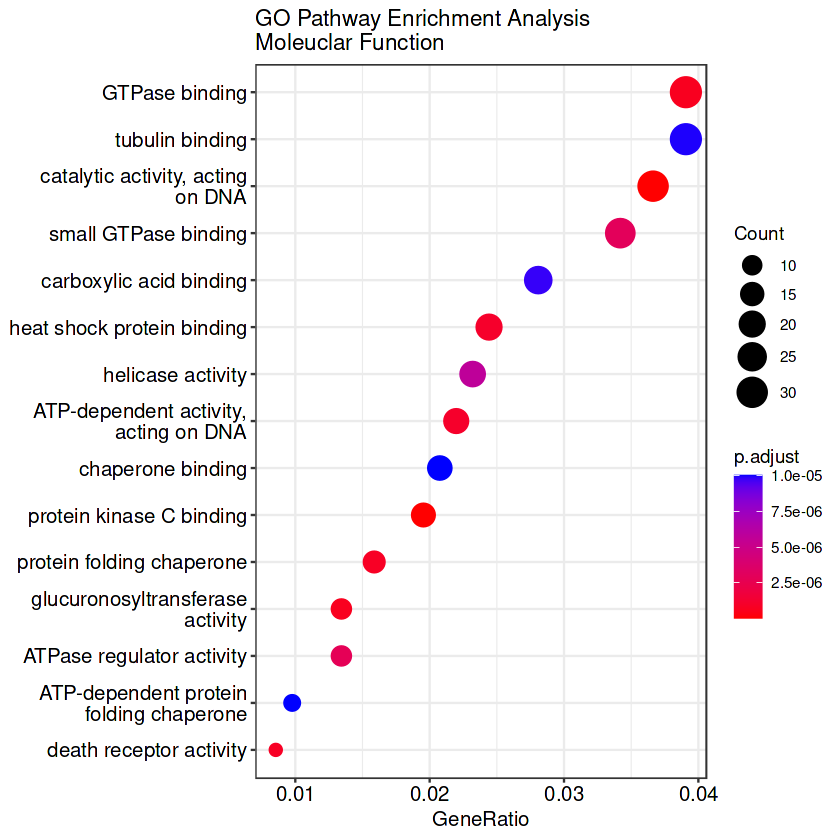

Pathway analysis GO:BP done

****************************************************************************************






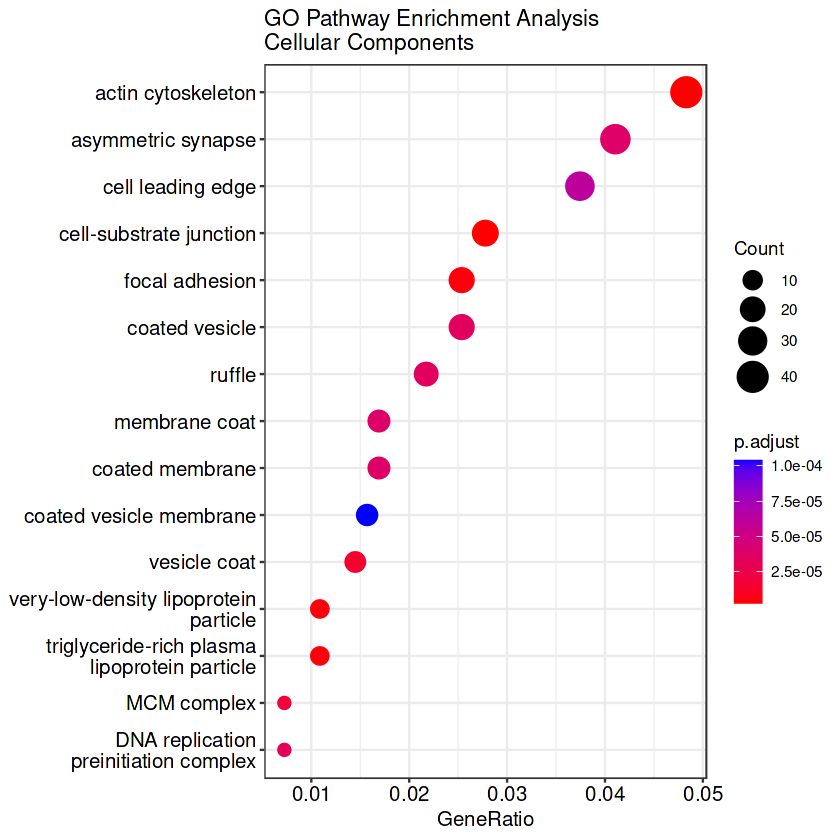

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = orgdb):
“1.74% of input gene IDs are fail to map...”
Pathway analysis GO:reactome done

****************************************************************************************






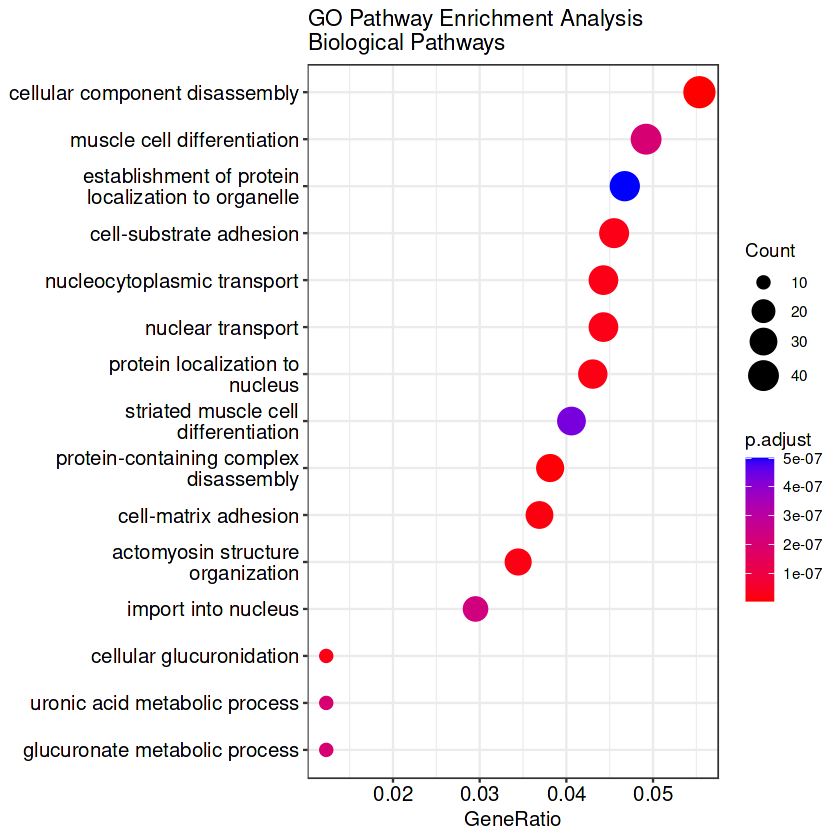

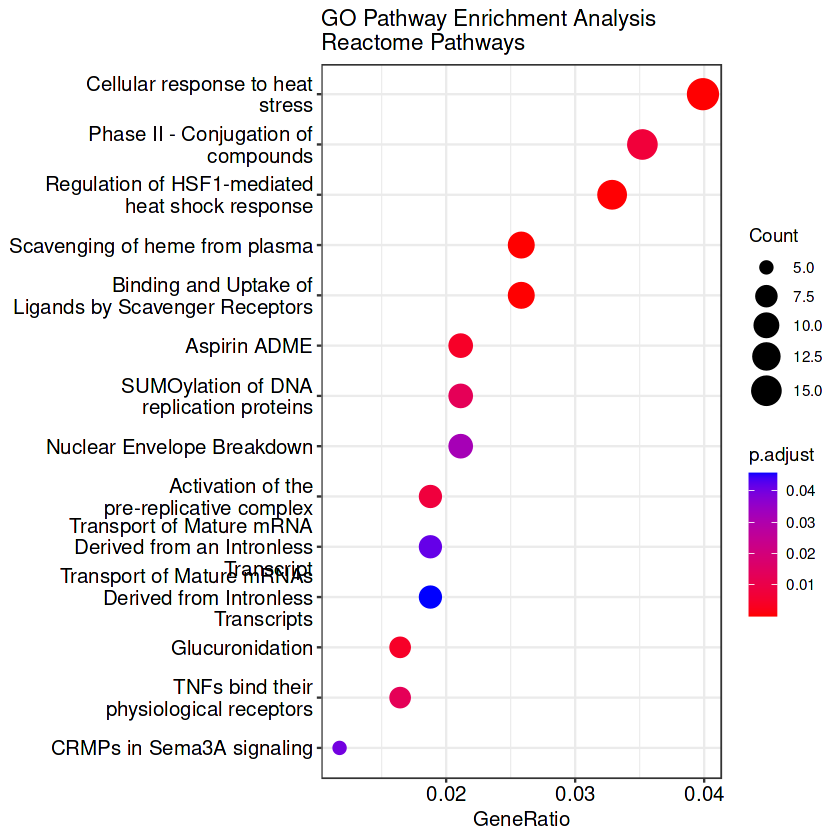

In [401]:
# Perform GO analysis on DEGs
dir.create("Results/GO", recursive = T) # create a GO directory to store results
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05)%>% pull(MGI.symbol)), pval = 0.05, onto = "MF", prefix = "Results/GO/KO_vs_WT", org = "mouse")
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05)%>% pull(MGI.symbol)), pval = 0.05, onto = "CC", prefix = "Results/GO/KO_vs_WT", org = "mouse")
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05)%>% pull(MGI.symbol)), pval = 0.05, onto = "BP", prefix = "Results/GO/KO_vs_WT", org = "mouse")
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05) %>% pull(MGI.symbol)), pval = 0.05, onto = "reactome", prefix = "Results/GO/KO_vs_WT", org = "mouse")



Pathway analysis GO:MF done

****************************************************************************************




Pathway analysis GO:CC done

****************************************************************************************






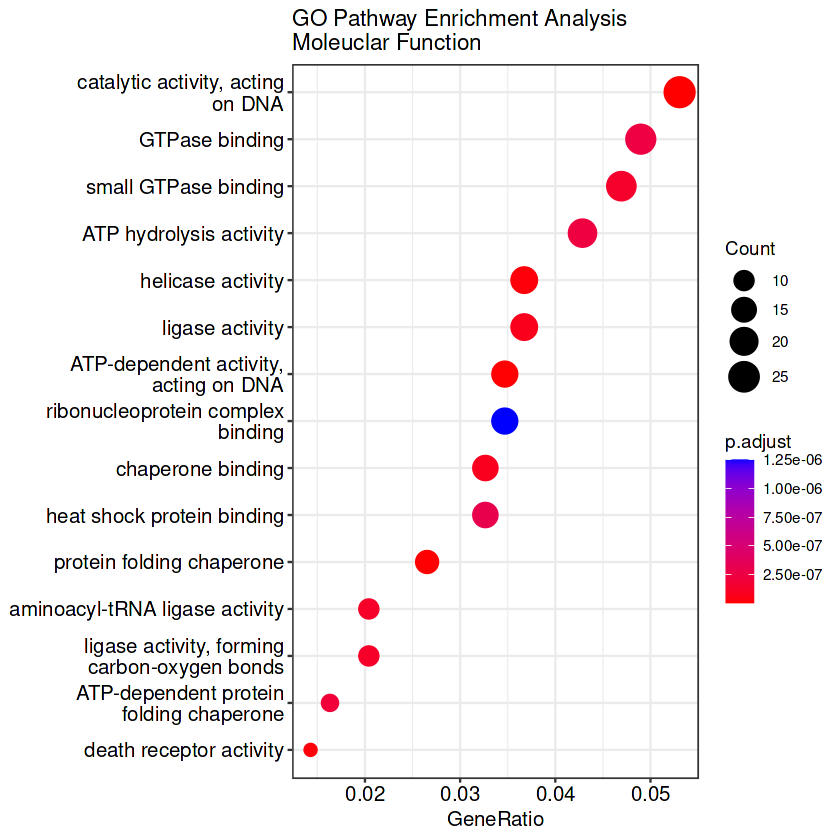

Pathway analysis GO:BP done

****************************************************************************************






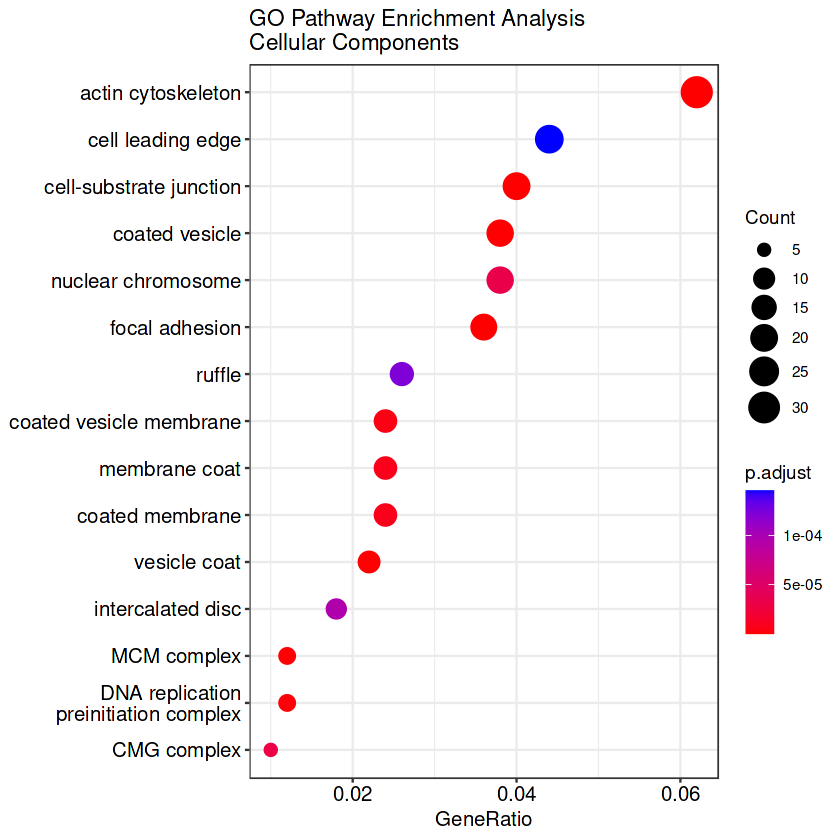

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = orgdb):
“1.55% of input gene IDs are fail to map...”
Pathway analysis GO:reactome done

****************************************************************************************






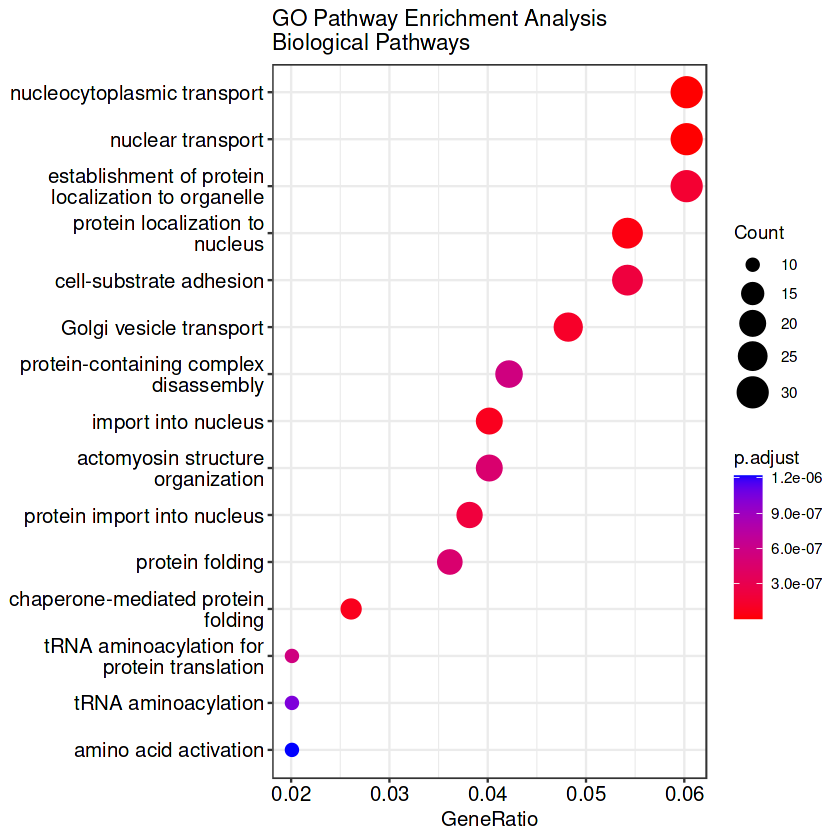

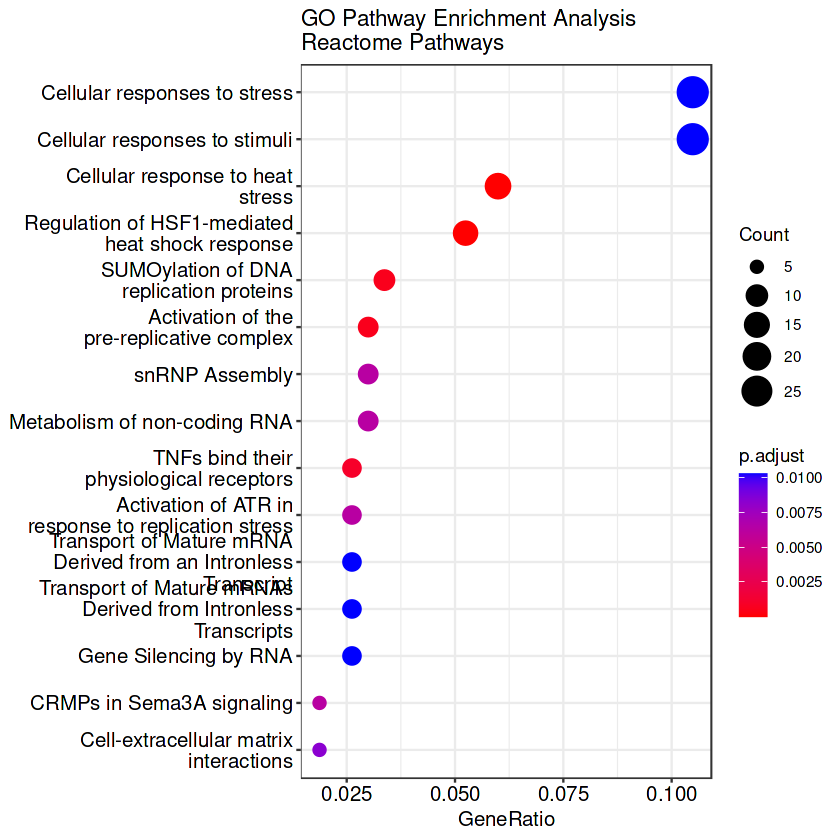

In [413]:
# Perform GO analysis on upregulated DEGs
dir.create("Results/GO/up/", recursive = T)
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05)%>%  filter(log2FoldChange > 0) %>% pull(MGI.symbol)), pval = 0.05, onto = "MF", prefix = "Results/GO/up/KO_vs_WT", org = "mouse")
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05)%>%  filter(log2FoldChange > 0) %>% pull(MGI.symbol)), pval = 0.05, onto = "CC", prefix = "Results/GO/up/KO_vs_WT", org = "mouse")
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05)%>% filter(log2FoldChange > 0) %>% pull(MGI.symbol)), pval = 0.05, onto = "BP", prefix = "Results/GO/up/KO_vs_WT", org = "mouse")
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05) %>% filter(log2FoldChange > 0) %>% pull(MGI.symbol)), pval = 0.05, onto = "reactome", prefix = "Results/GO/up/KO_vs_WT", org = "mouse")


Pathway analysis GO:MF done

****************************************************************************************




Pathway analysis GO:CC done

****************************************************************************************






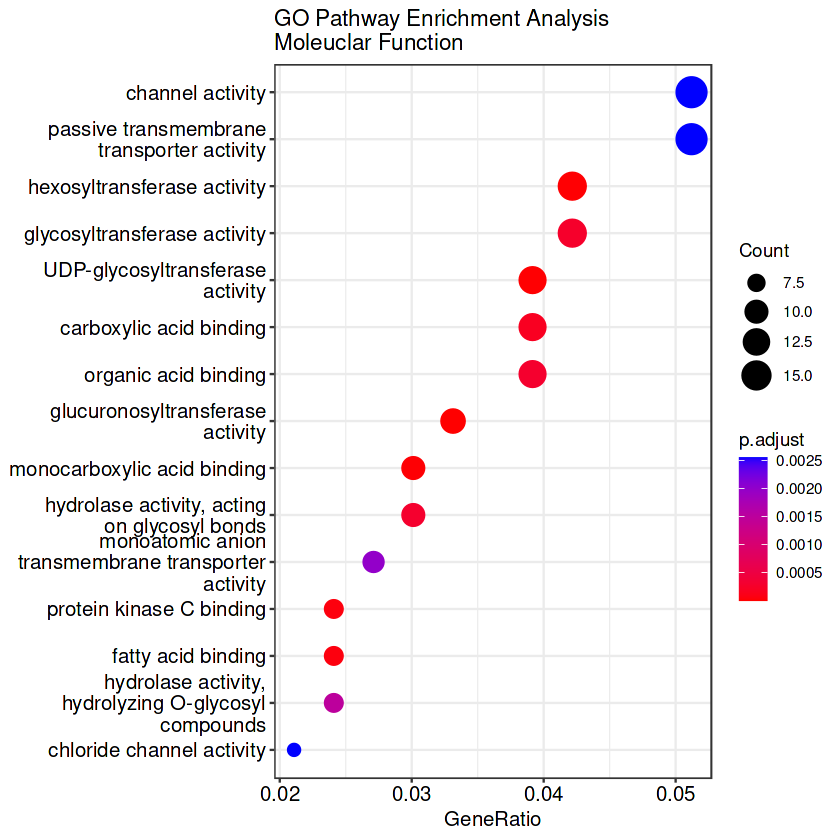

Pathway analysis GO:BP done

****************************************************************************************






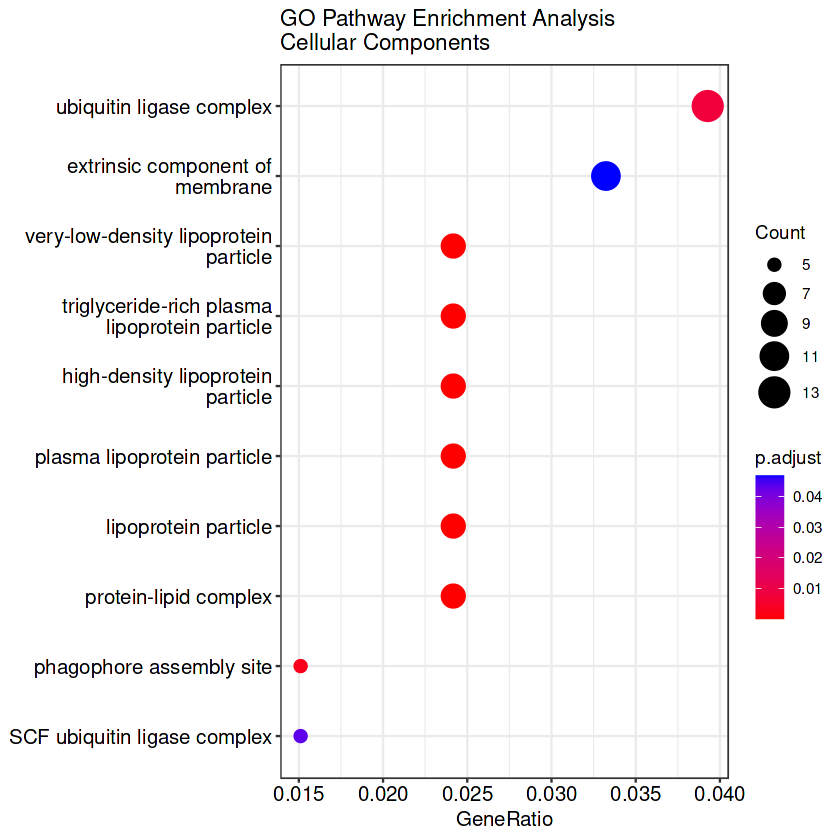

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = orgdb):
“2.28% of input gene IDs are fail to map...”
Pathway analysis GO:reactome done

****************************************************************************************






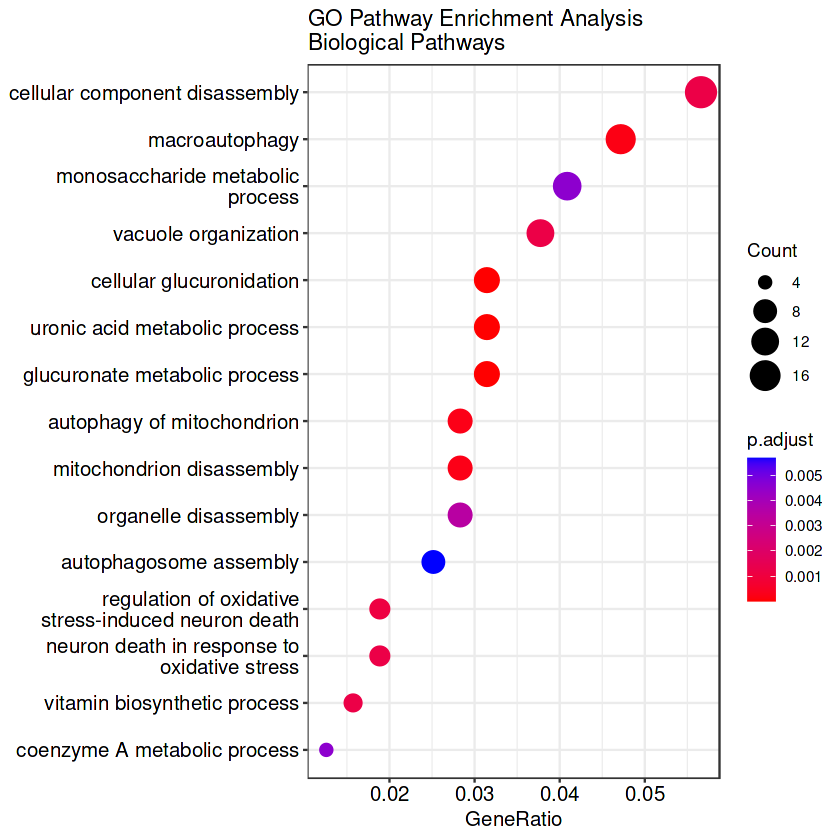

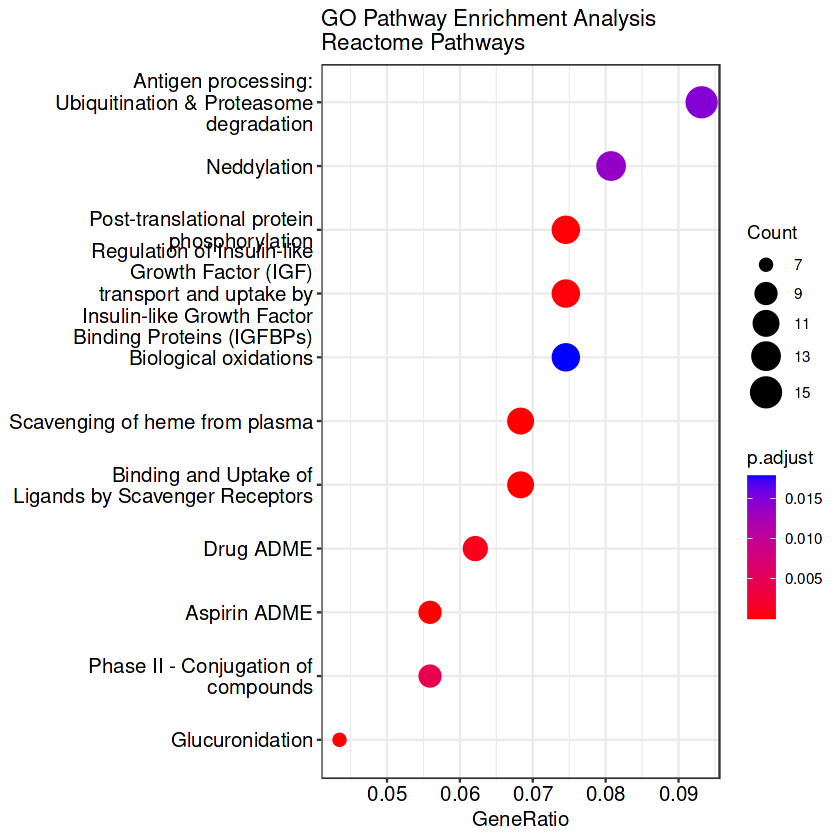

In [414]:
#  Perform GO analysis on downregulated DEGs
dir.create("Results/GO/down/", recursive = T)
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05)%>%  filter(log2FoldChange <= 0) %>% pull(MGI.symbol)), pval = 0.05, onto = "MF", prefix = "Results/GO/down/KO_vs_WT", org = "mouse")
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05)%>%  filter(log2FoldChange <= 0) %>% pull(MGI.symbol)), pval = 0.05, onto = "CC", prefix = "Results/GO/down/KO_vs_WT", org = "mouse")
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05)%>% filter(log2FoldChange <= 0) %>% pull(MGI.symbol)), pval = 0.05, onto = "BP", prefix = "Results/GO/down/KO_vs_WT", org = "mouse")
GO_function((results_WT_KO_df_gene_mouse %>% filter(padj<0.05) %>% filter(log2FoldChange <= 0) %>% pull(MGI.symbol)), pval = 0.05, onto = "reactome", prefix = "Results/GO/down/KO_vs_WT", org = "mouse")


    Oit3     Chd5   Npffr2    Gstt2    Hspa2    Smoc1 
6.678322 2.714058 2.667678 1.629230 1.555549 1.540089 


preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...

DEG Pathway analysis GSEA:MF for the provided dataset done

****************************************************************************************






    Oit3     Chd5   Npffr2    Gstt2    Hspa2    Smoc1 
6.678322 2.714058 2.667678 1.629230 1.555549 1.540089 


preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

No GP:CC obtained for the provided dataset

****************************************************************************************






    Oit3     Chd5   Npffr2    Gstt2    Hspa2    Smoc1 
6.678322 2.714058 2.667678 1.629230 1.555549 1.540089 


preparing geneSet collections...

GSEA analysis...

no term enriched under specific pvalueCutoff...

No GP:BP obtained for the provided dataset

****************************************************************************************






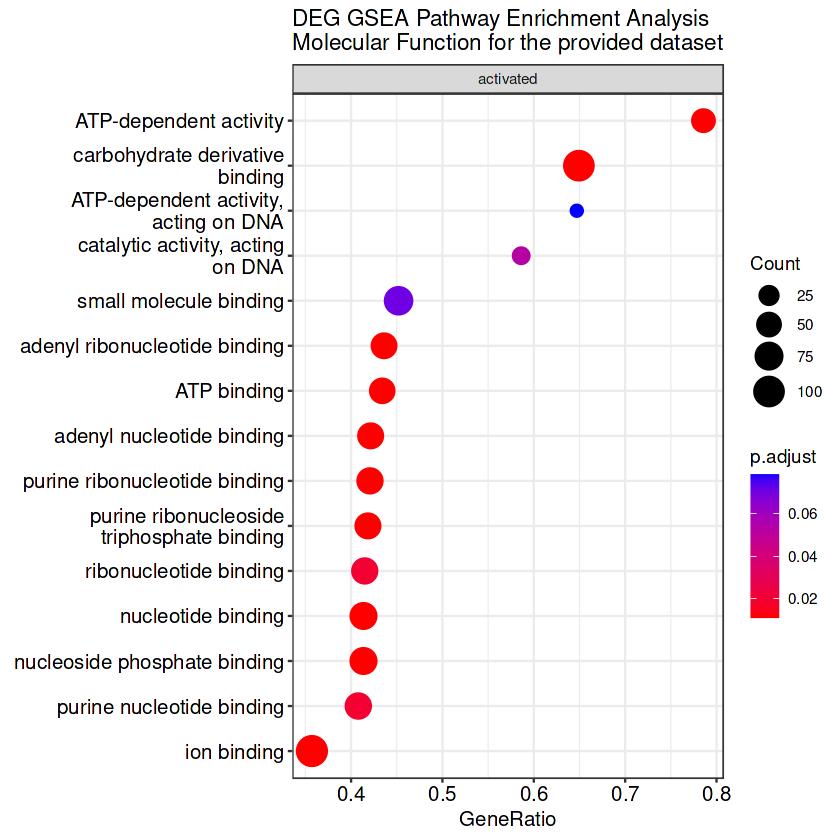

In [402]:
# GSEA function for bulk RNASeq data
GSEA_function_bulk <- function(df, pval_deg = 0.05, pval_enrich = 0.1, onto = "MF", prefix = "", pdf_width = 12, pdf_height = 12) {
    # df: data frame with log2FoldChange and padj columns
    # pval_deg: pvalue cutoff for DEGs
    # pval_enrich: pvalue cutoff for enrichment
    # onto: GO term
    # prefix: prefix for output file
    # pdf_width: width of pdf
    # pdf_height: height of pdf
    
    gene_list_df <- df[df$padj <= pval_deg, ] # get DEGs
    gene_list_df <- gene_list_df %>% arrange(desc(log2FoldChange)) # arrange by log2FoldChange
    gene_list_df <- gene_list_df[!is.na(gene_list_df$MGI.symbol), ] # remove NA
    gene_list_df <- gene_list_df[!duplicated(gene_list_df$MGI.symbol), ] # remove duplicates
    gene_list <- gene_list_df %>% pull(log2FoldChange) # get log2FoldChange
    names(gene_list) <- gene_list_df %>% pull(MGI.symbol) # set gene names as names of log2FoldChange
    gene_list <- gene_list[!duplicated(gene_list)] # remove duplicates
    print(head(gene_list)) # check file

    compGO <- gseGO(gene = gene_list, pvalueCutoff = pval_enrich, keyType = "SYMBOL",
                     pAdjustMethod = "BH", OrgDb = "org.Mm.eg.db", ont = onto) # run GSEA
    if (is.null(compGO) | nrow(compGO@result) == 0) { # check if compGO is null or if nrow of compGO@result is 0
        message(paste0("No GP:", onto, " obtained for the provided dataset"))
        message(paste0("****************************************************************************************"))
        message(paste0("\n"))
    } else { # if compGO is not null
        compGO_df <- as.data.frame(compGO) # convert to data frame
        compGO_df <- compGO_df %>% tidyr::separate_rows(core_enrichment, sep = "/", convert = FALSE) %>% arrange((p.adjust)) # separate core_enrichment column by / and arrange by p.adjust

        if (nrow(compGO_df) == 0) { # check if compGO_df is empty
            message(paste0("No GP:", onto, " obtained for the provided dataset"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))
        } else { # if compGO_df is not empty
            write.csv(compGO_df, paste0(prefix, "_GSEA_", onto, "_pathways.csv")) # write to csv

            full_name = switch(onto, # get full name of GO term
                MF = "Molecular Function",
                CC = "Cellular Components",
                BP = "Biological Pathways"
            )

            print(dotplot(compGO, showCategory = 15, title = paste0("DEG GSEA Pathway Enrichment Analysis \n", full_name, " for the provided dataset"),
                    font.size = 12) + facet_grid(.~.sign)) # plot dotplot
            dev.copy( # save plot
                pdf,
                file = paste0(prefix, "_GSEA_", onto, "_pathways.pdf"),
                width = pdf_width,
                height = pdf_height
            )
            dev.off ()

            message(paste0("DEG Pathway analysis GSEA:", onto, " for the provided dataset done"))
            message(paste0("****************************************************************************************"))
            message(paste0("\n"))
        }
    }
}
# Run GSEA on DEGs
dir.create("Results/GSEA", recursive = T)
GSEA_function_bulk(df = (results_WT_KO_df_gene_mouse %>% filter(padj<0.05)), pval_deg = 0.05, pval_enrich = 0.1, onto = "MF", prefix = "Results/GSEA/KO_vs_WT")
GSEA_function_bulk(df = (results_WT_KO_df_gene_mouse %>% filter(padj<0.05)), pval_deg = 0.05, pval_enrich = 0.1, onto = "CC", prefix = "Results/GSEA/KO_vs_WT")
GSEA_function_bulk(df = (results_WT_KO_df_gene_mouse %>% filter(padj<0.05)), pval_deg = 0.05, pval_enrich = 0.1, onto = "BP", prefix = "Results/GSEA/KO_vs_WT")


In [403]:
# Read in mitocarta file

mitocarta_mouse_pathways <- readxl::read_excel("/mnt/Data_8TB/Carolina_data/Cell_paper/Mouse.MitoCarta3.0.xls", sheet = 4)

mitocarta_mouse_pathways <- mitocarta_mouse_pathways %>% dplyr::select(MitoPathway, Genes)
# mitocarta_mouse_pathways %>% head
mitocarta_mouse_pathways_rows_list <- mitocarta_mouse_pathways %>% tidyr::separate_rows(Genes, sep = ",", convert = FALSE) %>%  arrange(MitoPathway) %>% dplyr::rename(term= MitoPathway,  gene= Genes)
# mitocarta_mouse_pathways_rows_list <- mitocarta_mouse_pathways_rows_list
# remove trailing and leading spaces
mitocarta_mouse_pathways_rows_list$gene <- gsub("^\\s+|\\s+$", "", mitocarta_mouse_pathways_rows_list$gene)
mitocarta_mouse_pathways_rows_list %>% head

term,gene
<chr>,<chr>
ABC transporters,Abca9
ABC transporters,Abcb10
ABC transporters,Abcb6
ABC transporters,Abcb7
ABC transporters,Abcb8
ABC transporters,Abcd1


In [404]:
# prepare data for GSEA on mitocarta pathways
gene_list_df <- results_WT_KO_df_gene_mouse[results_WT_KO_df_gene_mouse$padj<=0.05,] # get DEGs
gene_list_df <- gene_list_df %>% arrange(desc(log2FoldChange)) # arrange by log2FoldChange
gene_list_df <- gene_list_df[!is.na(gene_list_df$MGI.symbol),] # remove NA
gene_list_df <- gene_list_df[!duplicated(gene_list_df$MGI.symbol),] # remove duplicates
gene_list <- gene_list_df %>% pull(log2FoldChange) # get log2FoldChange
names(gene_list) <- gene_list_df %>% pull(MGI.symbol) # set gene names as names of log2FoldChange

gene_list <- gene_list[!duplicated(gene_list)] # remove duplicates
print(head(gene_list))  # check file

    Oit3     Chd5   Npffr2    Gstt2    Hspa2    Smoc1 
6.678322 2.714058 2.667678 1.629230 1.555549 1.540089 


In [405]:
names(gene_list)[names(gene_list) %in% mitocarta_mouse_pathways_rows_list$gene] # check if gene names are in mitocarta pathways
names(gene_list)[grepl("Cox7", names(gene_list))] # check if gene names are in mitocarta pathways
(mitocarta_mouse_pathways_rows_list$gene)[grepl("Cox7", (mitocarta_mouse_pathways_rows_list$gene))] # check if gene names are in mitocarta pathways

[1] "Mpv17l2"  "Kmo"      "Tbrg4"    "Endog"    "Lonp1"    "Hspd1"   
 [7] "Yars2"    "Acaa2"    "Acp6"     "Slc25a47" "Pdss2"    "Afg3l1"  
[13] "Akap1"    "Alas1"    "Ecsit"    "Hspa9"    "Abcb10"   "Gfm1"    
[19] "Iars2"    "Acaca"    "Ppm1k"    "Acss1"    "Marchf5"  "Amacr"   
[25] "Isca2"    "Mtx3"     "Gls2"     "Bnip3"    "Crot"     "Aldh5a1" 
[31] "Mterf4"   "Ngrn"     "Oxr1"     "Oxsm"     "Cyp27a1"  "Coq8a"   
[37] "Ak4"      "Slc25a32" "Aldh3a2"

character(0)

[1] "Cox7a1"  "Cox7a2"  "Cox7a2l" "Cox7b"   "Cox7c"   "Cox7a1"  "Cox7a2" 
 [8] "Cox7a2l" "Cox7b"   "Cox7c"   "Cox7a1"  "Cox7a2"  "Cox7a2l" "Cox7b"  
[15] "Cox7c"   "Cox7a2l" "Cox7a1"  "Cox7a2"  "Cox7a2l" "Cox7b"   "Cox7c"  
[22] "Cox7a2l"

preparing geneSet collections...



GSEA analysis...

leading edge analysis...

done...

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


pdf 
  4

png 
  2

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>,<chr>
Metabolism,Metabolism,Metabolism,22,-0.3414702,-1.474444,0.09794989,0.09794989,NA,273,"tags=64%, list=36%, signal=42%",Ppm1k/Acss1/Amacr/Isca2/Gls2/Crot/Aldh5a1/Oxr1/Oxsm/Cyp27a1/Coq8a/Ak4/Slc25a32/Aldh3a2


****************************************************************************************






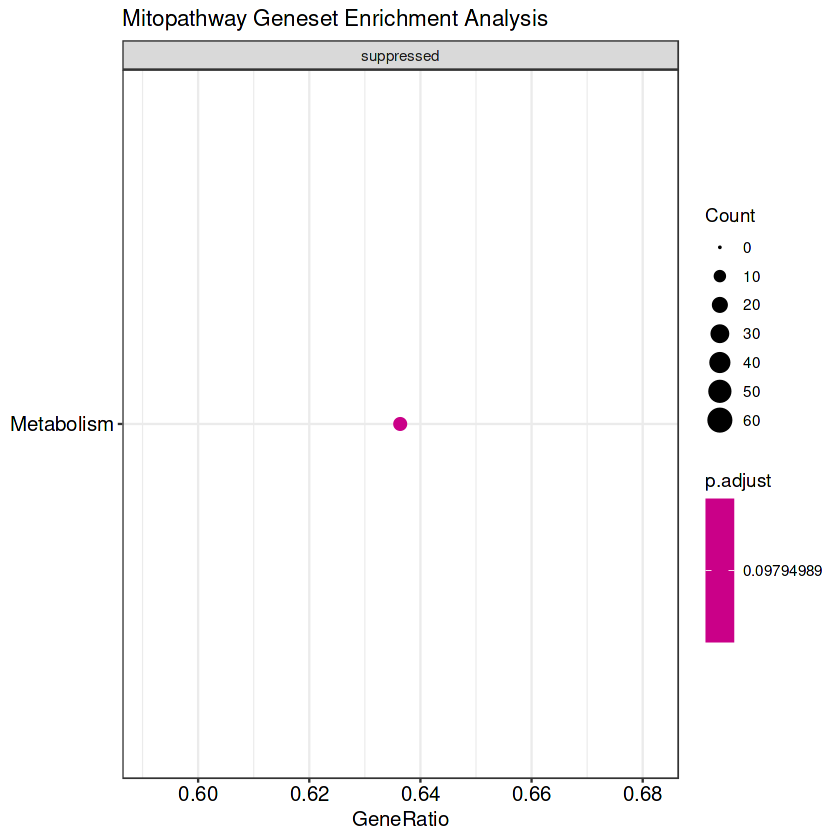

In [406]:
set.seed(123) # set seed
gsea_mito <- GSEA(gene_list, TERM2GENE = mitocarta_mouse_pathways_rows_list, pvalueCutoff = 0.2)
 dotplot(gsea_mito, showCategory = 15, title = paste0("Mitopathway Geneset Enrichment Analysis"), 
            font.size = 12) + facet_grid(.~.sign)+ scale_size_area(limits = c(0,60))+ # plot dotplot
            NULL # plot dotplot
    # Save dotplot as pdf file
    dev.copy(
    pdf,
    file = paste0("Results/GSEA/KO_vs_WT_Mitopathway_GSEA.pdf"),
    width = 22,
    height = 8
    )
    dev.off ()

    gsea_mito_df <- as.data.frame(gsea_mito)
        gsea_mito_df

    gsea_mito_df <- gsea_mito_df %>% tidyr::separate_rows(core_enrichment, sep = "/", convert = FALSE) %>%
      arrange((p.adjust))
    
    # Save enriched pathways data frame as CSV file
    write.csv(gsea_mito_df, paste0("Results/GSEA/KO_vs_WT_Mitopathway_GSEA.csv"))
    
    # Print message indicating that analysis for the current cell type is complete
#     message(paste0("Cell type: ", i, " done"))
    message(paste0("****************************************************************************************"))
    message(paste0("\n"))                              

# Prepare figure for Paper

In [560]:
BP <- read.csv("Results/GO/KO_vs_WT_GO_BP_pathways.csv") # read in GO BP file
# BP %>% head
MF <- read.csv("Results/GO/KO_vs_WT_GO_MF_pathways.csv") # read in GO MF file
# MF %>% head

# row bind all the data frames and add a column to indicate the GO term
BP$GO_class <- "Biological Process"
MF$GO_class <- "Molecular Functions"

# row bind all the data frames
GO_all <- rbind(BP, MF)
GO_all %>% head


,X,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,GeneRatio_decimal,BgRatio_decimal,GO_class
,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
1,1,GO:0022411,cellular component disassembly,45/813,450/28564,3.408267e-13,1.666642e-09,1.271104e-09,Grwd1,45,0.05535055,0.0157541,Biological Process
2,2,GO:0022411,cellular component disassembly,45/813,450/28564,3.408267e-13,1.666642e-09,1.271104e-09,Atp2a2,45,0.05535055,0.0157541,Biological Process
3,3,GO:0022411,cellular component disassembly,45/813,450/28564,3.408267e-13,1.666642e-09,1.271104e-09,Nav3,45,0.05535055,0.0157541,Biological Process
4,4,GO:0022411,cellular component disassembly,45/813,450/28564,3.408267e-13,1.666642e-09,1.271104e-09,Hif1a,45,0.05535055,0.0157541,Biological Process
5,5,GO:0022411,cellular component disassembly,45/813,450/28564,3.408267e-13,1.666642e-09,1.271104e-09,Abce1,45,0.05535055,0.0157541,Biological Process
6,6,GO:0022411,cellular component disassembly,45/813,450/28564,3.408267e-13,1.666642e-09,1.271104e-09,Gsn,45,0.05535055,0.0157541,Biological Process


In [561]:
# Select pathways to plot
terms_for_figure <- c("cell-substrate adhesion", 
"striated muscle cell differentiation", 
"regulation of vasculature development", 
"positive regulation of cell projection organization", 
"regulation of actin filament-based process", 
"regulation of actin cytoskeleton organization", 
"mitotic cell cycle phase transition", 
"cellular response to oxidative stress", 
"striated muscle tissue development", 
"actin binding", 
"histone binding", 
"DNA helicase activity", 
"calcium ion transmembrane transporter activity", 
"UDP-glycosyltransferase activity")

In [562]:
terms_for_figure

[1] "cell-substrate adhesion"                            
 [2] "striated muscle cell differentiation"               
 [3] "regulation of vasculature development"              
 [4] "positive regulation of cell projection organization"
 [5] "regulation of actin filament-based process"         
 [6] "regulation of actin cytoskeleton organization"      
 [7] "mitotic cell cycle phase transition"                
 [8] "cellular response to oxidative stress"              
 [9] "striated muscle tissue development"                 
[10] "actin binding"                                      
[11] "histone binding"                                    
[12] "DNA helicase activity"                              
[13] "calcium ion transmembrane transporter activity"     
[14] "UDP-glycosyltransferase activity"

In [587]:
GO_all_figure <- GO_all %>% dplyr::filter(Description %in% terms_for_figure) # filter based on terms_for_figure
GO_all_figure$Description <- str_to_title(GO_all_figure$Description) # make description oin title case
GO_all_figure$Description[GO_all_figure$Description=="Dna Helicase Activity"] <- "DNA Helicase Activity" # correct spelling
GO_all_figure$Description[GO_all_figure$Description=="Udp-Glycosyltransferase Activity"] <- "UDP-Glycosyltransferase Activity" # correct spelling

GO_all_figure <- GO_all_figure %>% group_by(GO_class) %>% arrange((GeneRatio_decimal)) %>% ungroup() # arrange by GeneRatio_decimal
GO_all_figure %>% head # check file
GO_all_figure$Description <- factor(GO_all_figure$Description, levels=unique(GO_all_figure$Description)) # set levels for description

GO_all_figure %>% str
GO_all_figure$Description %>% unique() 
GO_all_figure$GeneRatio_decimal %>% max

X,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count,GeneRatio_decimal,BgRatio_decimal,GO_class
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
1157,GO:0003678,DNA Helicase Activity,9/819,56/28171,3.162251e-05,0.0008110243,0.0006069955,Ddx3x,9,0.01098901,0.00198786,Molecular Functions
1158,GO:0003678,DNA Helicase Activity,9/819,56/28171,3.162251e-05,0.0008110243,0.0006069955,D1Pas1,9,0.01098901,0.00198786,Molecular Functions
1159,GO:0003678,DNA Helicase Activity,9/819,56/28171,3.162251e-05,0.0008110243,0.0006069955,G3bp1,9,0.01098901,0.00198786,Molecular Functions
1160,GO:0003678,DNA Helicase Activity,9/819,56/28171,3.162251e-05,0.0008110243,0.0006069955,Mcm5,9,0.01098901,0.00198786,Molecular Functions
1161,GO:0003678,DNA Helicase Activity,9/819,56/28171,3.162251e-05,0.0008110243,0.0006069955,Mcm3,9,0.01098901,0.00198786,Molecular Functions
1162,GO:0003678,DNA Helicase Activity,9/819,56/28171,3.162251e-05,0.0008110243,0.0006069955,Mcm4,9,0.01098901,0.00198786,Molecular Functions


tibble [329 × 13] (S3: tbl_df/tbl/data.frame)
 $ X                : int [1:329] 1157 1158 1159 1160 1161 1162 1163 1164 1165 1095 ...
 $ ID               : chr [1:329] "GO:0003678" "GO:0003678" "GO:0003678" "GO:0003678" ...
 $ Description      : Factor w/ 14 levels "DNA Helicase Activity",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ GeneRatio        : chr [1:329] "9/819" "9/819" "9/819" "9/819" ...
 $ BgRatio          : chr [1:329] "56/28171" "56/28171" "56/28171" "56/28171" ...
 $ pvalue           : num [1:329] 3.16e-05 3.16e-05 3.16e-05 3.16e-05 3.16e-05 ...
 $ p.adjust         : num [1:329] 0.000811 0.000811 0.000811 0.000811 0.000811 ...
 $ qvalue           : num [1:329] 0.000607 0.000607 0.000607 0.000607 0.000607 ...
 $ geneID           : chr [1:329] "Ddx3x" "D1Pas1" "G3bp1" "Mcm5" ...
 $ Count            : int [1:329] 9 9 9 9 9 9 9 9 9 11 ...
 $ GeneRatio_decimal: num [1:329] 0.011 0.011 0.011 0.011 0.011 ...
 $ BgRatio_decimal  : num [1:329] 0.00199 0.00199 0.00199 0.00199 0.00199 ...
 $ GO_

[1] DNA Helicase Activity                              
 [2] Calcium Ion Transmembrane Transporter Activity     
 [3] UDP-Glycosyltransferase Activity                   
 [4] Histone Binding                                    
 [5] Striated Muscle Tissue Development                 
 [6] Cellular Response To Oxidative Stress              
 [7] Regulation Of Vasculature Development              
 [8] Mitotic Cell Cycle Phase Transition                
 [9] Regulation Of Actin Cytoskeleton Organization      
[10] Regulation Of Actin Filament-Based Process         
[11] Actin Binding                                      
[12] Striated Muscle Cell Differentiation               
[13] Positive Regulation Of Cell Projection Organization
[14] Cell-Substrate Adhesion                            
14 Levels: DNA Helicase Activity ...

[1] 0.04551046

pdf 
  4

png 
  2

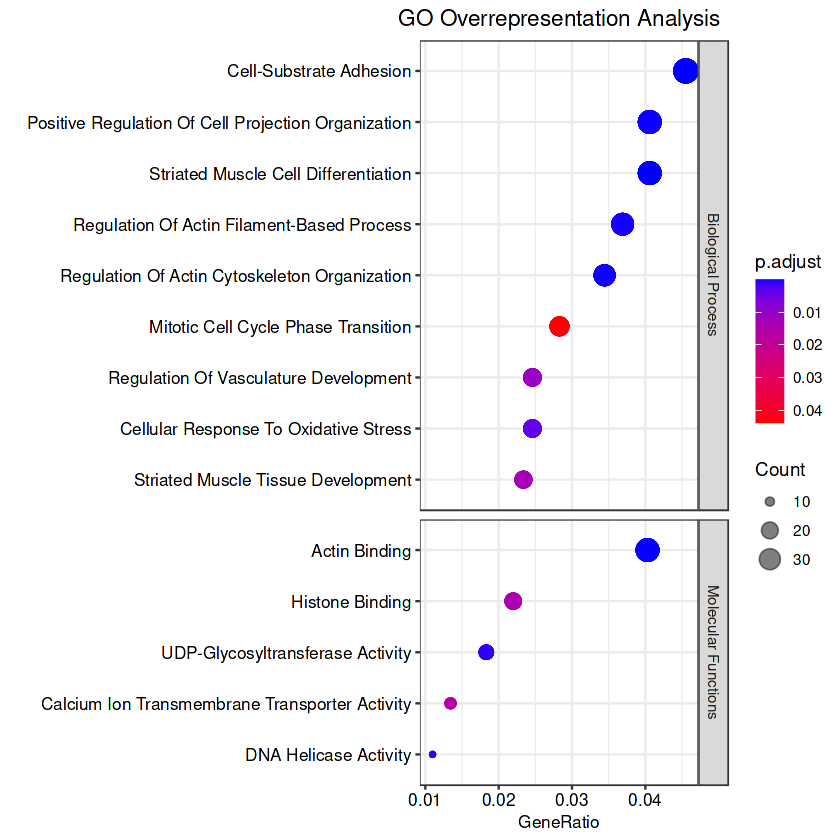

In [590]:
# create dotplot for the GO terms with GeneRatio_decimal on x axis decreasing generatio , and GO term on y axis, color by p.adjust size of dot by Count

options(ggrepel.max.overlaps = 50)
 
    ggplot(data = (GO_all_figure  ) , # make ggplot object 
    aes(x = GeneRatio_decimal, y = Description,  # x axis is GeneRatio_decimal, y axis is Description
    color = p.adjust, size = Count)) + # color by p.adjust, size of dot by Count
        geom_point(alpha = 0.5) + # add points with alpha 0.5
        scale_color_gradient(low = "blue", high = "red",guide=guide_colourbar(reverse = TRUE)) + # set color gradient to blue to red
        facet_grid(vars(GO_class), scales = "free",  space = "free_y") + # facet by GO_class with free scales and free y axis
        theme_bw() + # set theme to black and white
        labs(title = "GO Overrepresentation Analysis", x = "GeneRatio", y = "") + # set title and axis labels
        theme(plot.title = element_text(hjust = 0.5), axis.text = element_text(size = 10), # set theme for plot title and axis text
              axis.title.x = element_text(size = 10), axis.title.y = element_text(size = 10),
              axis.text.x=element_text(colour="black"),
              axis.text.y=element_text(colour="black")) +
        NULL
    # Save dotplot as pdf file
    dev.copy(
    pdf,
    file = paste0("Results/GO/Figure_KO_vs_WT_GO_pathways.pdf"),
    width = 7,
    height = 6
    )
    dev.off ()

# save data and session info

In [407]:
save.image("DEG_Cox7aKO_7dpi.RData")

In [3]:
load("DEG_Cox7aKO_7dpi.RData")

In [5]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.10.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_CH.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_CH.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_CH.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_CH.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Zurich
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] clusterProfiler_4.8.1       DESeq2_1.40.1              
 [3] SummarizedExperiment_1.30.2 Biobase_2.60.0             
 [5] MatrixGenerics_1.12.2       matrixStats_1.0.0          
 [7] Genomic